## Crime data

In [70]:
from dask_cloudprovider.aws import EC2Cluster 
from dask.distributed import Client
import configparser
import os
import contextlib
import re
import dask
from platform import python_version

def get_aws_credentials():
    """Read in your AWS credentials file and convert to environment variables."""
    parser = configparser.RawConfigParser()
    
    parser.read(os.path.expanduser('~/.aws/config'))
    config = parser.items('default')
    
    parser.read(os.path.expanduser('~/.aws/credentials'))
    credentials = parser.items('default')
    
    all_credentials = {key.upper(): value for key, value in [*config, *credentials]}
    with contextlib.suppress(KeyError):
        all_credentials["AWS_REGION"] = all_credentials.pop("REGION")
        
    return all_credentials

# Pass in AWS Credentials + any extra packages you would like to install on cluster via `pip`
env_vars = get_aws_credentials()
env_vars["EXTRA_PIP_PACKAGES"] = "s3fs"

# Select software installed on scheduler + worker instances based on client Python + Dask versions
# versions need to match across client, scheduler, worker -- slight mismatches are OK, though
py_v = '-py' + re.findall(r'\d{1}.\d+', python_version())[0]
dask_docker_tag = f"daskdev/dask:{dask.__version__ + py_v}"
print('Docker Image: ', dask_docker_tag)

# launch a cluster of 5 r5.large instances (10 vCPUs):
# 1 scheduler
# 4 workers (2 threads + 16 GB RAM each)
cluster = EC2Cluster(instance_type='r5.large',
                     n_workers=4,
                     security=False,
                     docker_image=dask_docker_tag,
                     env_vars=env_vars
)

Docker Image:  daskdev/dask:2024.5.0-py3.12
Creating scheduler instance
Created instance i-06de2635fffa1aa4c as dask-d7393b7c-scheduler
Waiting for scheduler to run at 54.87.109.127:8786
Scheduler is running
Creating worker instance
Creating worker instance
Creating worker instance


/opt/anaconda3/lib/python3.12/contextlib.py:144: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources. Hang tight! 
  next(self.gen)


Creating worker instance
Created instance i-066456d426cd78c28 as dask-d7393b7c-worker-5bdf8713
Created instance i-0e5e9d695b93072f7 as dask-d7393b7c-worker-c3a9a7ab
Created instance i-020bce6d2de49b4f2 as dask-d7393b7c-worker-0457de88
Created instance i-0b0d682a98527f754 as dask-d7393b7c-worker-55510525


In [2]:
client = Client(cluster)
client.wait_for_workers(4)

In [7]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read data
ddf = dd.read_parquet(
    "s3://paul-project-bucket/features/crime_monthly_totals",
    storage_options={"anon": False}
)
# Basic stats
print("Row count:", ddf.shape[0].compute())
print("Date range:", ddf["month"].min().compute(), "to", ddf["month"].max().compute())
print("Unique hex_ids:", ddf["hex_id"].nunique().compute())

# Sample data
print(ddf.head(3))

Row count: 6373
Date range: 2014-01 to 2024-12


2025-05-24 19:01:30,045 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f0dfcd5e10666c236605842be24b3532 initialized by task ('shuffle-transfer-f0dfcd5e10666c236605842be24b3532', 0) executed on worker tcp://127.0.0.1:63911
2025-05-24 19:01:30,061 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f0dfcd5e10666c236605842be24b3532 deactivated due to stimulus 'task-finished-1748131290.060569'


Unique hex_ids: 51
   hex_id    month  total_crime
0       2  2014-11            6
1       2  2017-03           10
2       2  2019-09            9


### 1. Distribution of Log-Transformed Crime Counts
In the first analysis, I examine the empirical distribution of crime counts by plotting the log-transformed histogram of “total_crime + 1,” overlaying a kernel density estimate (KDE) and marking the median. By applying the log transform, extreme values in the tail are compressed, allowing the reader to discern more clearly the central tendency of the data. The resulting density is roughly symmetric around log 3.5–4.0 (approximately 20–55 incidents per hex–month), while the pronounced right tail—extending beyond log 6—signals a small number of exceptionally high-crime observations. The vertical line at log 3.78 emphasizes that half of all hex–months record fewer than 44 incidents, setting a useful benchmark for distinguishing routine from anomalous crime levels.

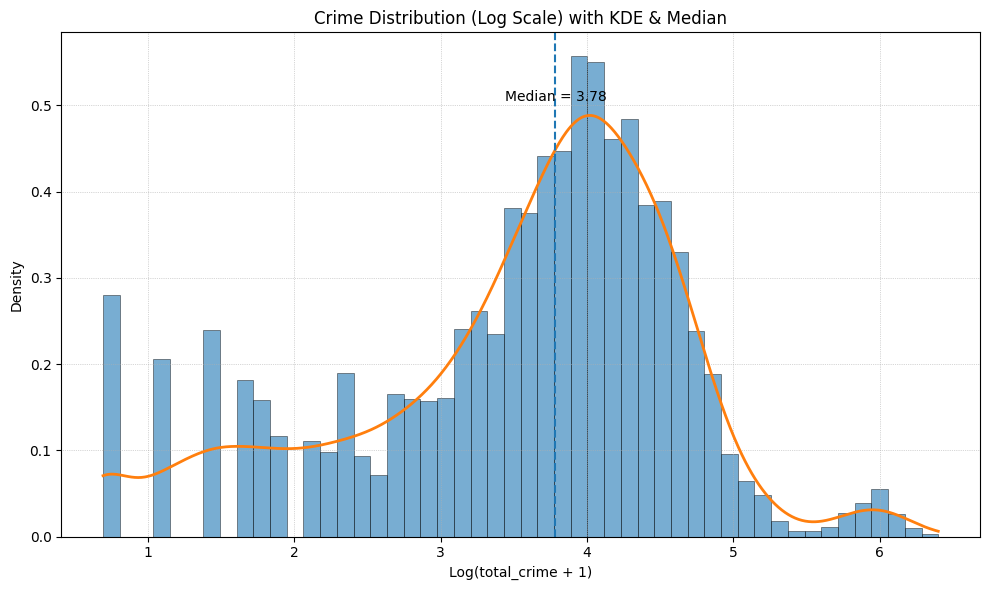

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Compute and log-transform
crime_vals = ddf["total_crime"].values.compute()
log_crime = np.log1p(crime_vals)

# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram (density)
counts, bins, _ = ax.hist(
    log_crime,
    bins=50,
    density=True,
    alpha=0.6,
    edgecolor='k',
    linewidth=0.5
)

# Kernel density estimate
kde = gaussian_kde(log_crime)
x_grid = np.linspace(log_crime.min(), log_crime.max(), 1000)
ax.plot(x_grid, kde(x_grid), lw=2)

# Median line
median_val = np.median(log_crime)
ax.axvline(median_val, linestyle='--', linewidth=1.5)
ax.text(
    median_val,
    counts.max() * 0.9,
    f'Median = {median_val:.2f}',
    ha='center',
    va='bottom'
)

# Labels, title, grid
ax.set_xlabel("Log(total_crime + 1)")
ax.set_ylabel("Density")
ax.set_title("Crime Distribution (Log Scale) with KDE & Median")
ax.grid(True, linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

### 2. Cumulative Crime Totals by Hexagon (2014–2024)
To identify where those anomalies concentrate, I aggregate crime counts over the entire 2014–2024 period and rank the hexagons by their cumulative totals. The top cell alone accounts for over 50 000 incidents—more than twice the count of the next most active cell—while the remainder of the top ten each record between about 10 000 and 21 000 crimes. This steep drop-off underscores that crime in Toronto is disproportionately localized: a handful of grid cells dominate the overall incident volume.


/var/folders/9v/swhhkcgn3h543bcvl6qz76lc0000gn/T/ipykernel_38122/3034534898.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


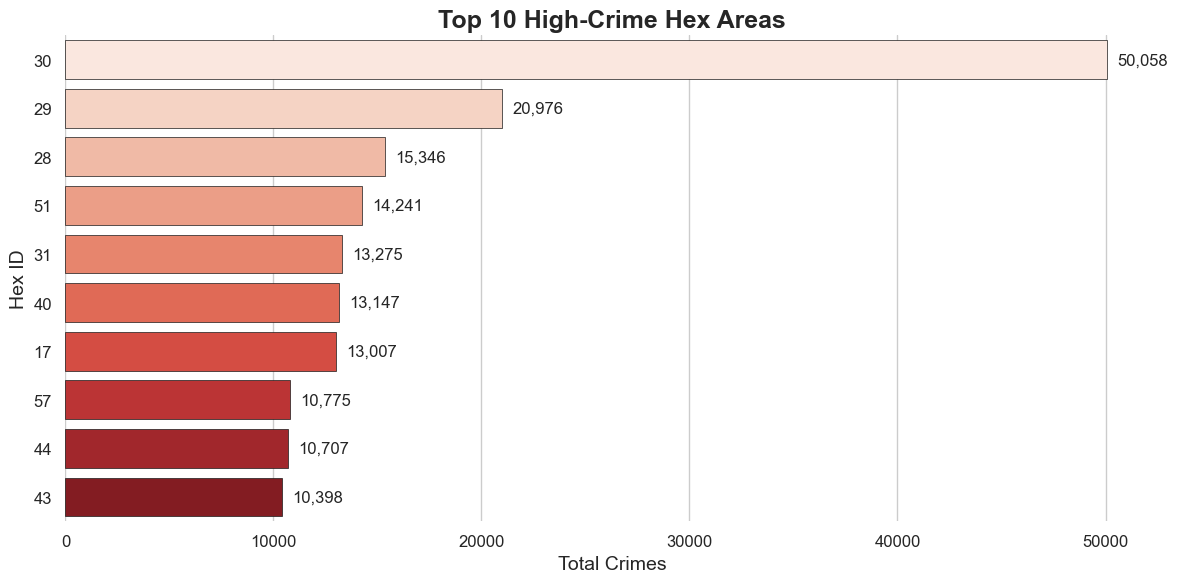

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute top 10 hex areas by total crime
top_locations = ddf.groupby("hex_id")["total_crime"].sum().nlargest(10).compute()
hex_ids = top_locations.index.astype(str)
crime_counts = top_locations.values

# Apply a clean Seaborn style
sns.set_theme(style="whitegrid")

# Create the barplot
fig, ax = plt.subplots(figsize=(12, 6))
palette = sns.color_palette("Reds", n_colors=len(hex_ids))
sns.barplot(
    x=crime_counts,
    y=hex_ids,
    palette=palette,
    edgecolor="k",
    linewidth=0.5,
    ax=ax
)

# Annotate each bar with the crime count
for idx, value in enumerate(crime_counts):
    ax.text(
        value + crime_counts.max() * 0.01,  # slight offset to the right
        idx,
        f"{int(value):,}",
        va="center",
        fontsize=12
    )

# Improve labels and title
ax.set_title("Top 10 High-Crime Hex Areas", fontsize=18, fontweight="bold")
ax.set_xlabel("Total Crimes", fontsize=14)
ax.set_ylabel("Hex ID", fontsize=14)
ax.tick_params(axis="both", labelsize=12)

# Remove excess spines for a cleaner look
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

### 3. Aggregate Crime by Official Neighbourhood
Comparing hexagonal aggregation with official neighbourhood boundaries reveals a related but less uniform picture. When neighbourhoods are ordered by total crime, West Humber–Clairville and Moss Park lead with roughly 11 600 and 9 400 incidents, respectively, followed by downtown cores such as Downtown Yonge East and York University Heights. However, these administrative units vary widely in their geographic extent and shape, complicating direct comparisons of density or feature extraction. In contrast, hexagons of equal area and shape provide a consistent spatial framework for modeling local crime intensity.


2025-05-24 19:11:28,568 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle bbbfcd657452ca37f00d607efd026b56 initialized by task ('shuffle-transfer-bbbfcd657452ca37f00d607efd026b56', 9) executed on worker tcp://127.0.0.1:63910
2025-05-24 19:11:37,117 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle bbbfcd657452ca37f00d607efd026b56 deactivated due to stimulus 'task-finished-1748131897.117268'


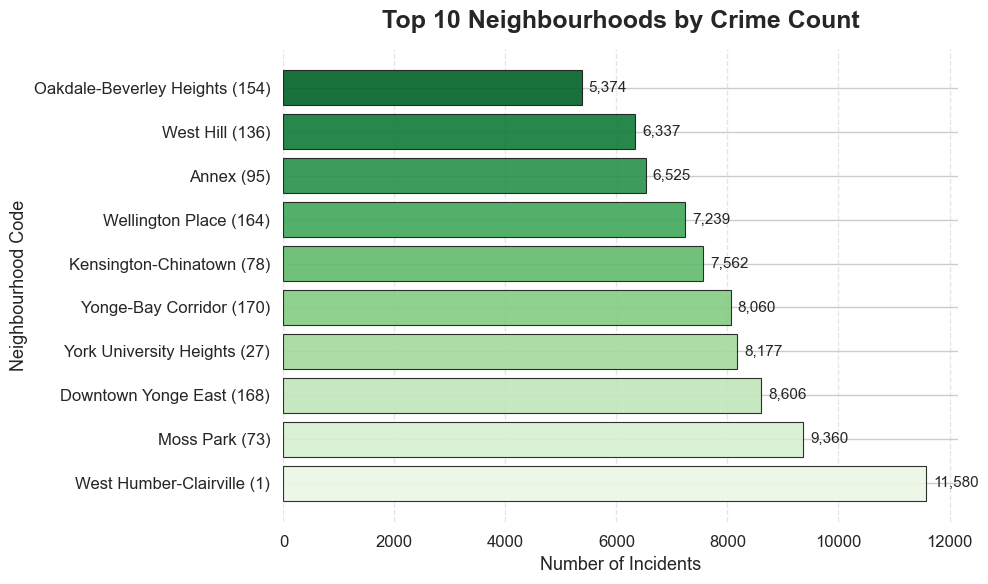

In [21]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

# Read parquet and compute top-10 neighbourhoods by crime count
ddf = dd.read_parquet(
    "s3://paul-project-bucket/tps/cleaned/crime_rounded_coords",
    storage_options={'anon': False},
    engine="pyarrow"
)
top10 = (
    ddf['NEIGHBOURHOOD_158']
      .value_counts()
      .nlargest(10)
      .compute()
)

# Set up Seaborn theme
sns.set_theme(style="whitegrid")

# Prepare data
labels = top10.index.astype(str)
counts = top10.values
palette = sns.color_palette("Greens", n_colors=len(labels))

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(labels, counts, color=palette, edgecolor='k', linewidth=0.8, alpha=0.9)

# Annotate each bar with its count
ax.bar_label(bars, labels=[f"{c:,}" for c in counts], padding=5, fontsize=11)

# Styling tweaks
ax.set_title("Top 10 Neighbourhoods by Crime Count", fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Number of Incidents", fontsize=13)
ax.set_ylabel("Neighbourhood Code", fontsize=13)
ax.tick_params(axis="both", labelsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

### 4.Crime Density across Toronto: Hex-bin Aggregation (2014–2024)
A spatial heat-map of crime density over the full decade further highlights the rationale for hex-binning. Plotting cumulative incident counts in each hexagon against Toronto’s municipal outline reveals a bright core in the downtown and along major commercial corridors, while suburban and peripheral areas remain comparatively muted. The hex grid not only captures these broad clusters but also allows for seamless computation of spatial covariates—such as land-use mix, vegetation indices, or proximity to transit—within each cell.


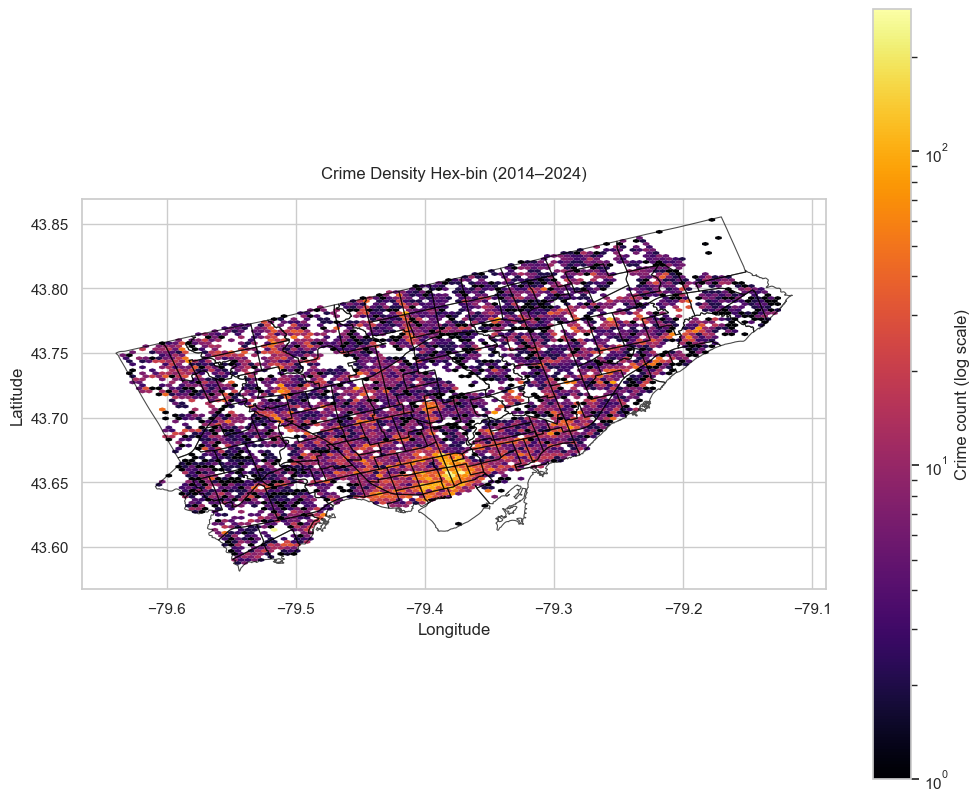

In [22]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from shapely.geometry import Point
import matplotlib.patheffects as path_effects

pdf = ddf.sample(frac=0.1).compute()

# Fetch the 158-neighbourhood boundaries on the fly
arcgis_url = (
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
)
nbhd_gdf = gpd.read_file(arcgis_url).to_crs(epsg=4326)

# Draw a log-scaled hexbin of crime points
fig, ax = plt.subplots(figsize=(12, 10))

hb = ax.hexbin(
    pdf["LONG_WGS84"],
    pdf["LAT_WGS84"],
    gridsize=100,                   
    mincnt=1,                          
    cmap="inferno",                    
    norm=colors.LogNorm(vmin=1),      
    edgecolors="none"
)

cb = fig.colorbar(hb, ax=ax)
cb.set_label("Crime count (log scale)")

# Overlay the neighbourhood boundaries
nbhd_gdf.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.8,
    alpha=0.7
)

# 5) Final styling
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Crime Density Hex-bin (2014–2024)", pad=15)
ax.set_aspect("equal", "box")

plt.show()

### 5. Monthly Crime Trends and Seasonal Cycle (2013–2024)
Temporal dynamics are equally important, so I chart total monthly crime counts from October 2013 through the present, together with a three-month rolling average. The series exhibits a pronounced seasonal cycle (summer peaks, winter troughs) and a gradual upward trend culminating in a peak of 3 742 incidents in August 2023. Notable deviations—such as the downturn in late 2014 and the pandemic‐related drop in spring 2020—illustrate the influence of external shocks on urban crime. These patterns justify modeling at the hex–month level, where both intra-seasonal fluctuations and long-run trends can be incorporated into predictive features.

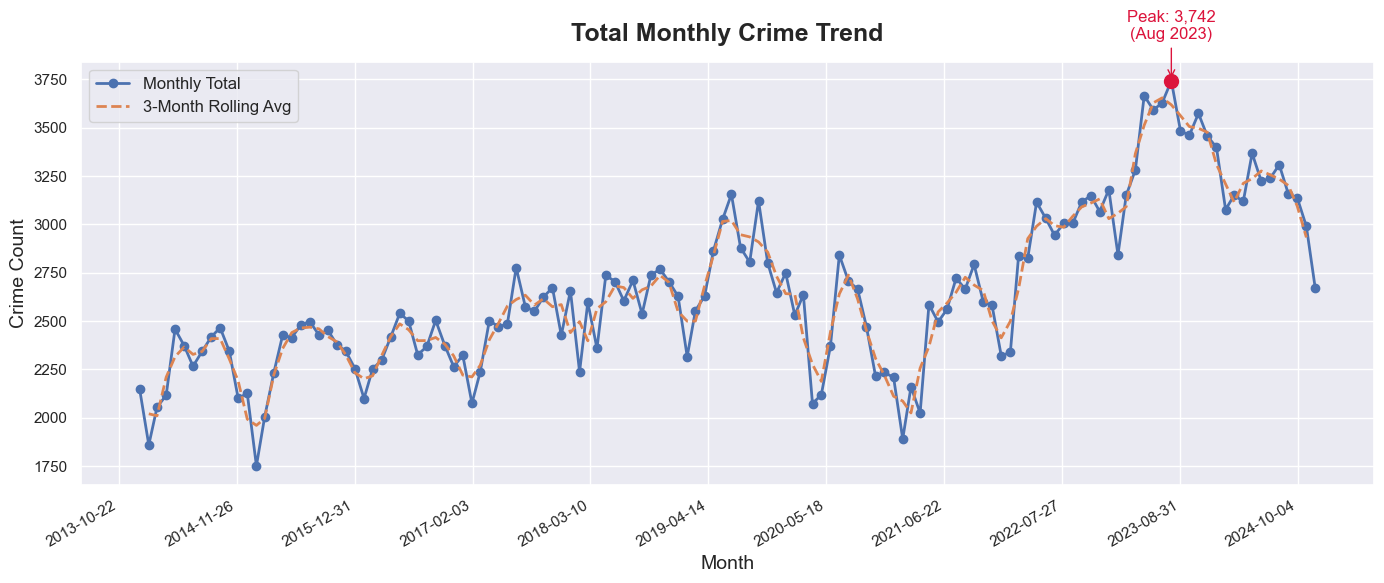

In [24]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
ddf = dd.read_parquet(
    "s3://paul-project-bucket/features/crime_monthly_totals",
    storage_options={"anon": False}
)

# Compute and prepare monthly trend
monthly_trend = ddf.groupby("month")["total_crime"].sum().compute()
monthly_trend.index = pd.to_datetime(monthly_trend.index, format="%Y-%m")

# Set Seaborn theme
sns.set_theme(style="darkgrid")

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the raw monthly totals with markers
ax.plot(
    monthly_trend.index,
    monthly_trend.values,
    marker="o",
    linewidth=2,
    label="Monthly Total"
)

# Overlay a 3-month rolling average
rolling = monthly_trend.rolling(window=3, center=True).mean()
ax.plot(
    rolling.index,
    rolling.values,
    linestyle="--",
    linewidth=2,
    label="3-Month Rolling Avg"
)

# Highlight and annotate the peak month
peak_month = monthly_trend.idxmax()
peak_val   = monthly_trend.max()
ax.scatter(peak_month, peak_val, color="crimson", s=100, zorder=5)
ax.annotate(
    f"Peak: {peak_val:,}\n({peak_month:%b %Y})",
    xy=(peak_month, peak_val),
    xytext=(0, 30),
    textcoords="offset points",
    ha="center",
    fontsize=12,
    color="crimson",
    arrowprops=dict(arrowstyle="->", color="crimson")
)

# Final styling
ax.set_title("Total Monthly Crime Trend", fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Crime Count", fontsize=14)
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
fig.autofmt_xdate()
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

### 6. Crime Intensity per Hexagon: August 2015
To demonstrate the granularity afforded by the hex grid, I map a single busy month—August 2015—showing the raw incident count per hexagon. Even within one month, the downtown core’s cells register hundreds of incidents, while outlying cells record almost none, and secondary hotspots appear near transit hubs. This snapshot confirms that hexagons strike an effective balance: they are sufficiently fine-grained to resolve micro-hotspots yet large enough to accumulate meaningful counts, making them ideal units for subsequent feature engineering and spatiotemporal modeling of crime intensity.

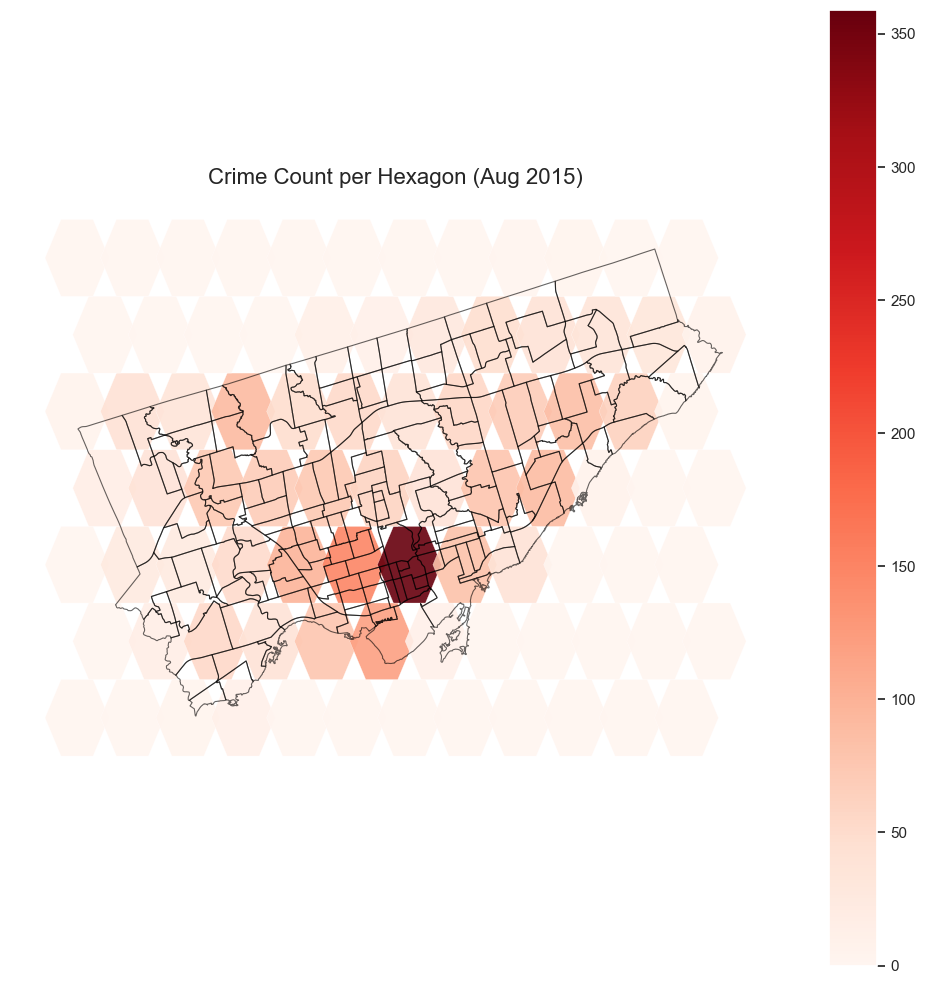

In [26]:

import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt

ddf_hex = dd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = gpd.GeoDataFrame(
    pdf_hex[["hex_id", "geometry"]],
    geometry="geometry", crs="EPSG:4326"
)

# Aggregate crime for a single month
year, month = 2015, 8

ddf_crime = dd.read_parquet(
    "s3://paul-project-bucket/features/crime_daily",
    storage_options={"anon": False},
    engine="pyarrow"
).reset_index().assign(
    year=lambda df: df.day.dt.year,
    month=lambda df: df.day.dt.month
)

ddf_mon = (
    ddf_crime[
      (ddf_crime.year  == year) &
      (ddf_crime.month == month)
    ]
    .groupby("hex_id")
    .crime_n
    .sum()
    .rename("crime_count")
    .to_frame()
)

pdf_mon = ddf_mon.compute().reset_index()
pdf_mon["hex_id"] = pdf_mon.hex_id.astype(gdf_hex.hex_id.dtype)
gdf_mon = gdf_hex.merge(pdf_mon, on="hex_id", how="left").fillna(0)

# Fetch neighbourhood boundaries & reproject 
arcgis_url = (
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
)
nbhd_gdf = gpd.read_file(arcgis_url).to_crs(epsg=4326)

# Reproject both to Web Mercator
gdf_mon_3857  = gdf_mon.to_crs(epsg=3857)
nbhd_gdf_3857 = nbhd_gdf.to_crs(epsg=3857)

# Plot hex‐grid crime + neighbourhood outlines
fig, ax = plt.subplots(figsize=(10, 10))

# plot hexes colored by crime_count
gdf_mon_3857.plot(
    column="crime_count",
    cmap="Reds",   
    legend=True,
    edgecolor="white",
    linewidth=0.2,
    alpha=0.9,
    ax=ax
)

# overlay neighbourhood boundaries
nbhd_gdf_3857.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.8,
    alpha=0.6
)

ax.set_title(f"Crime Count per Hexagon (Aug 2015)", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()

### 7. Spatial Evolution of Monthly Crime Intensity by Hexagon (2023)
A panel of maps displaying each month of 2023 traces the shifting contours of urban crime over time. The persistent core in the downtown area remains dominant throughout the year, but peripheral fluctuations—such as milder winter peaks and sharper summer highs—become readily apparent when viewed in sequence. This month‐by‐month mosaic conveys not only where crime concentrates, but also how its intensity and spread evolve with seasonal and contextual factors, reinforcing the need to include temporal indicators in any spatiotemporal crime model.

/var/folders/9v/swhhkcgn3h543bcvl6qz76lc0000gn/T/ipykernel_38122/2709985044.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


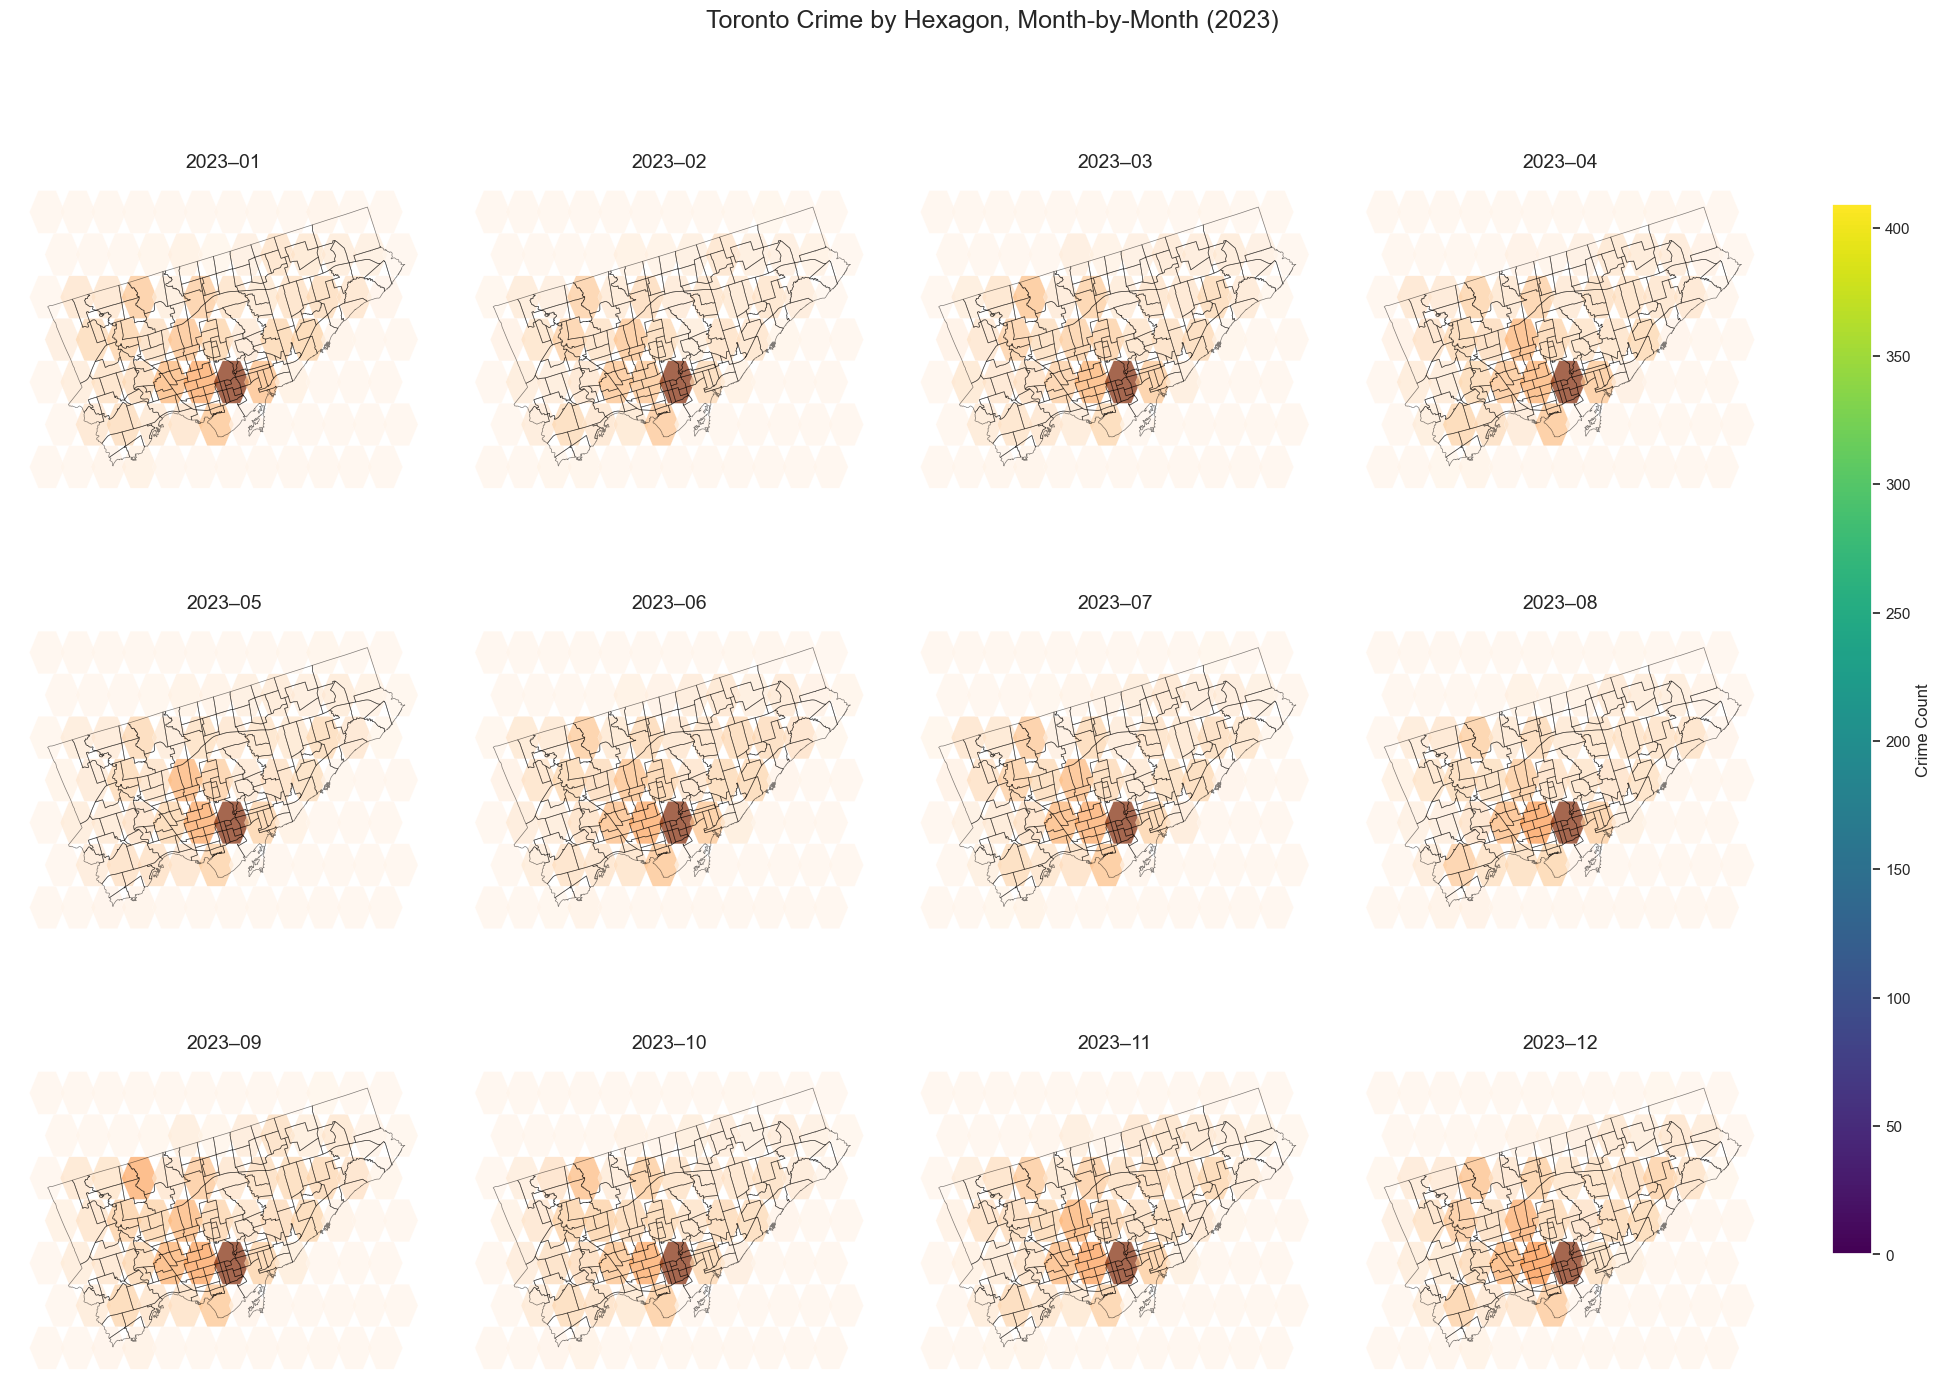

In [27]:

import dask.dataframe as dd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt

# Load your hex grid & reproject to Web Mercator
ddf_hex = dd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = gpd.GeoDataFrame(
    pdf_hex[["hex_id", "geometry"]],
    geometry="geometry",
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Load neighbourhood boundaries & reproject
nbhd_gdf = gpd.read_file(
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
).to_crs(epsg=3857)

# Read daily crime, extract year/month
ddf_crime = (
    dd.read_parquet(
        "s3://paul-project-bucket/features/crime_daily",
        storage_options={"anon": False},
        engine="pyarrow"
    )
    .reset_index()
    .assign(
        year=lambda df: df.day.dt.year,
        month=lambda df: df.day.dt.month
    )
)

# Set up 3×4 grid of subplots with correct args
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharex=True, sharey=True)
axes = axes.flatten()

for m, ax in enumerate(axes, start=1):
    # filter to August etc.
    ddf_mon = (
        ddf_crime[(ddf_crime.year == 2023) & (ddf_crime.month == m)]
        .groupby("hex_id")
        .crime_n
        .sum()
        .rename("crime_count")
        .to_frame()
    )
    pdf_mon = ddf_mon.compute().reset_index()
    pdf_mon["hex_id"] = pdf_mon.hex_id.astype(gdf_hex.hex_id.dtype)

    # merge into hex grid
    gdf_mon = gdf_hex.merge(pdf_mon, on="hex_id", how="left").fillna(0)

    gdf_mon.plot(
        column="crime_count",
        cmap="Oranges",
        legend=False,
        edgecolor="white",
        linewidth=0.2,
        alpha=0.7,
        ax=ax
    )
    nbhd_gdf.boundary.plot(ax=ax, color="black", linewidth=0.5, alpha=0.5)
    ax.set_title(f"2023–{m:02d}", fontsize=14)
    ax.axis("off")

# single colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(
    cmap="viridis",
    norm=plt.Normalize(vmin=0, vmax=gdf_mon.crime_count.max())
)
sm._A = []
fig.colorbar(sm, cax=cax, label="Crime Count")

plt.suptitle("Toronto Crime by Hexagon, Month-by-Month (2023)", fontsize=18)
plt.tight_layout(rect=[0, 0, 0.9, 0.96])
plt.show()

In [29]:
import dask.dataframe as dd
import geopandas as gpd
import matplotlib.pyplot as plt
import imageio
import pandas as pd
from shapely import wkt
import contextily as ctx
from io import BytesIO

# Load & prepare static layers once
ddf_hex = dd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = gpd.GeoDataFrame(
    pdf_hex[["hex_id", "geometry"]],
    geometry="geometry",
    crs="EPSG:4326"
).to_crs(epsg=3857)

nbhd_gdf = gpd.read_file(
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
).to_crs(epsg=3857)

# Load crime data and extract year/month
ddf_crime = (
    dd.read_parquet(
        "s3://paul-project-bucket/features/crime_daily",
        storage_options={"anon": False},
        engine="pyarrow"
    )
    .reset_index()
    .assign(
        year=lambda df: df.day.dt.year,
        month=lambda df: df.day.dt.month
    )
)

# Prepare to collect frames
frames = []

for m in range(1, 13):
    # Compute monthly counts
    ddf_mon = (
        ddf_crime[(ddf_crime.year == 2023) & (ddf_crime.month == m)]
        .groupby("hex_id")
        .crime_n
        .sum()
        .reset_index()
        .rename(columns={"crime_n": "crime_count"})
    )
    pdf_mon = ddf_mon.compute()
    pdf_mon["hex_id"] = pdf_mon.hex_id.astype(gdf_hex.hex_id.dtype)
    gdf_mon = gdf_hex.merge(pdf_mon, on="hex_id", how="left").fillna(0)
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    gdf_mon.plot(
        column="crime_count",
        cmap="Oranges",
        legend=False,
        edgecolor="white",
        linewidth=0.2,
        alpha=0.7,
        ax=ax
    )
    nbhd_gdf.boundary.plot(ax=ax, color="black", linewidth=0.5, alpha=0.5)
    ax.set_title(f"2023–{m:02d}", fontsize=14)
    ax.axis("off")
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=10)
    
    # Capture the frame
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=150, bbox_inches="tight")
    buf.seek(0)
    frames.append(imageio.v2.imread(buf))
    plt.close(fig)

# Write out animated GIF
imageio.mimsave("toronto_crime_2023.gif", frames, fps=2)

### 8. Interannual Comparison of September Crime Distribution by Hexagon (2015–2024)
Finally, mapping September of each year from 2015 through 2024 facilitates a year‐over-year assessment of crime dispersion during a consistent seasonal window. While the downtown core invariably remains the hottest zone, the depth of its intensity and the reach of secondary clusters vary from year to year—reflecting broader social and policy shifts. The relative attenuation in September 2020 compared to pre-pandemic levels, followed by a resurgence in subsequent years, underscores the influence of external shocks. This interannual perspective validates our choice of hexagonal units and highlights the importance of capturing both spatial and temporal heterogeneity when modeling urban crime patterns.

/var/folders/9v/swhhkcgn3h543bcvl6qz76lc0000gn/T/ipykernel_38122/3860899513.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.9,0.95])


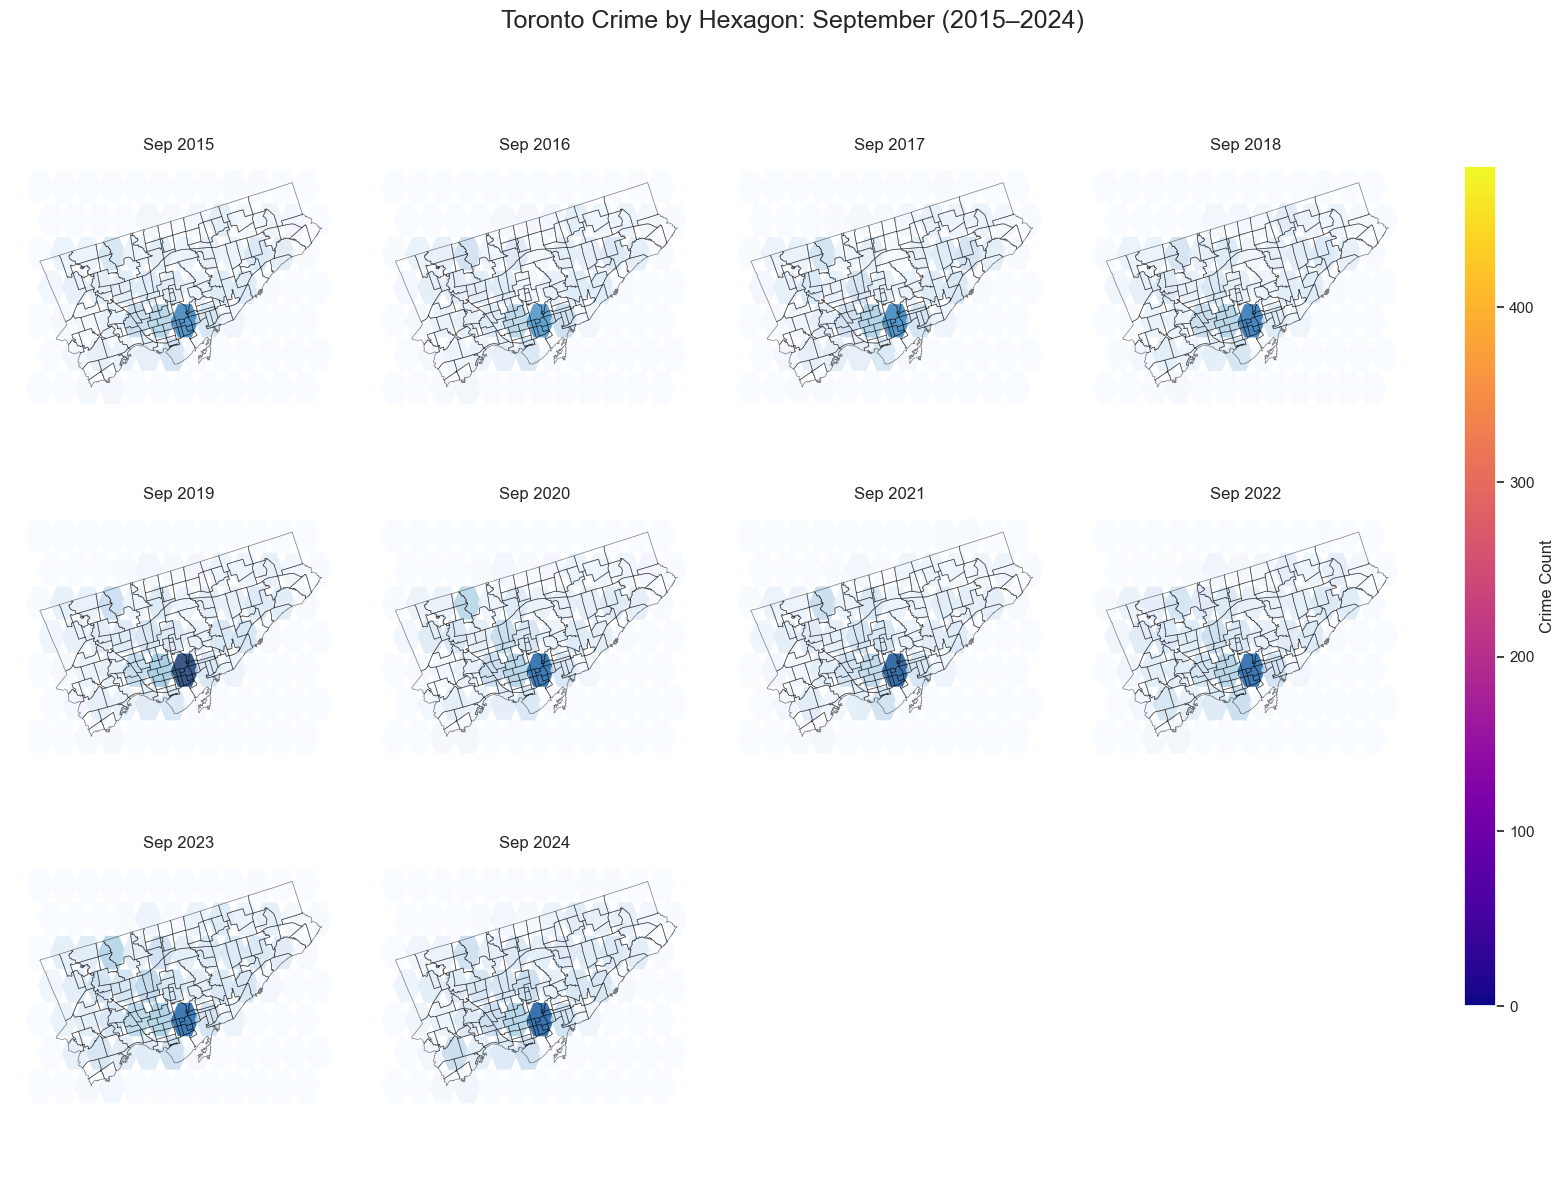

In [28]:

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt

# Load hex grid & neighbourhood boundaries
pdf_hex = pd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    engine="pyarrow",
    storage_options={"anon": False}
)
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = gpd.GeoDataFrame(
    pdf_hex[["hex_id","geometry"]],
    geometry="geometry",
    crs="EPSG:4326"
).to_crs(epsg=3857)

nbhd_gdf = gpd.read_file(
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
).to_crs(epsg=3857)

# Load & prep crime data
df_crime = pd.read_parquet(
    "s3://paul-project-bucket/features/crime_daily",
    engine="pyarrow",
    storage_options={"anon": False}
).reset_index()
df_crime["year"]  = df_crime.day.dt.year
df_crime["month"] = df_crime.day.dt.month

# Build per-September sums
years = list(range(2015,2025))
monthly = {}
max_cnt = 0
for yr in years:
    pdf_mon = (
        df_crime[(df_crime.year==yr)&(df_crime.month==9)]
        .groupby("hex_id")
        .crime_n.sum()
        .rename("crime_count")
        .reset_index()
    )
    monthly[yr] = pdf_mon
    if not pdf_mon.empty:
        max_cnt = max(max_cnt, pdf_mon.crime_count.max())

# Plot in a 4-columns layout
cols = 4
rows = (len(years) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4),
                         sharex=True, sharey=True)
axes = axes.flatten()

for ax, yr in zip(axes, years):
    pdf_mon = monthly[yr]
    pdf_mon["hex_id"] = pdf_mon.hex_id.astype(gdf_hex.hex_id.dtype)
    gdf_mon = gdf_hex.merge(pdf_mon, on="hex_id", how="left").fillna(0)
    gdf_mon.plot(
        column="crime_count",
        cmap="Blues",
        vmin=0, vmax=max_cnt,
        edgecolor="white",
        linewidth=0.2,
        alpha=0.8,
        ax=ax
    )
    nbhd_gdf.boundary.plot(
        ax=ax,
        color="black",
        linewidth=0.5,
        alpha=0.5
    )
    ax.set_title(f"Sep {yr}")
    ax.axis("off")

# turn off any unused subplots
for ax in axes[len(years):]:
    ax.axis("off")

# shared colorbar
sm = plt.cm.ScalarMappable(
    cmap="plasma",
    norm=plt.Normalize(0, max_cnt)
)
sm._A = []
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sm, cax=cbar_ax, label="Crime Count")

plt.suptitle("Toronto Crime by Hexagon: September (2015–2024)", fontsize=18)
plt.tight_layout(rect=[0,0,0.9,0.95])
plt.show()

### 9. ACF and PACF
The autocorrelation function (ACF) of the monthly crime‐count series exhibits a very slow, monotonic decay: the first lag exceeds 0.88 (well beyond the 95 % confidence bounds), the second and third lags remain above 0.80 and 0.70 respectively, and even by the fifth lag the autocorrelation still hovers around 0.62.  Such a pattern is characteristic of a highly persistent stochastic process, indicating that observed crime levels in any given month carry over strongly into subsequent months.  The absence of an abrupt cutoff in the ACF suggests that simple moving‐average (MA) components alone would struggle to capture this inertia and that differencing or autoregressive (AR) structure is required to achieve stationarity.

Turning to the partial autocorrelation function (PACF), we see a very large spike at lag 1 (≈ 0.88) followed by an immediate drop to near‐zero values for most higher lags, with only a modest secondary bump around lag 5 (≈ 0.18).  This sharply truncating behavior in the PACF provides formal justification for modeling the series as an AR(1) process: virtually all the month‐to‐month dependence is explained by a single one‐period lag once intermediate correlations are accounted for.  The small but statistically discernible peak at the fifth lag hints at a weaker cyclical component—perhaps driven by reporting or seasonal effects—that could be accommodated by either a seasonal AR term at lag 5 or by including an exogenous indicator for five‐month intervals.  Overall, these diagnostics recommend first differencing or detrending the series, followed by estimating a parsimonious ARIMA(1,1,0) (or ARIMA(1,0,0) if stationarity already holds), before investigating any higher‐order or seasonal extensions.

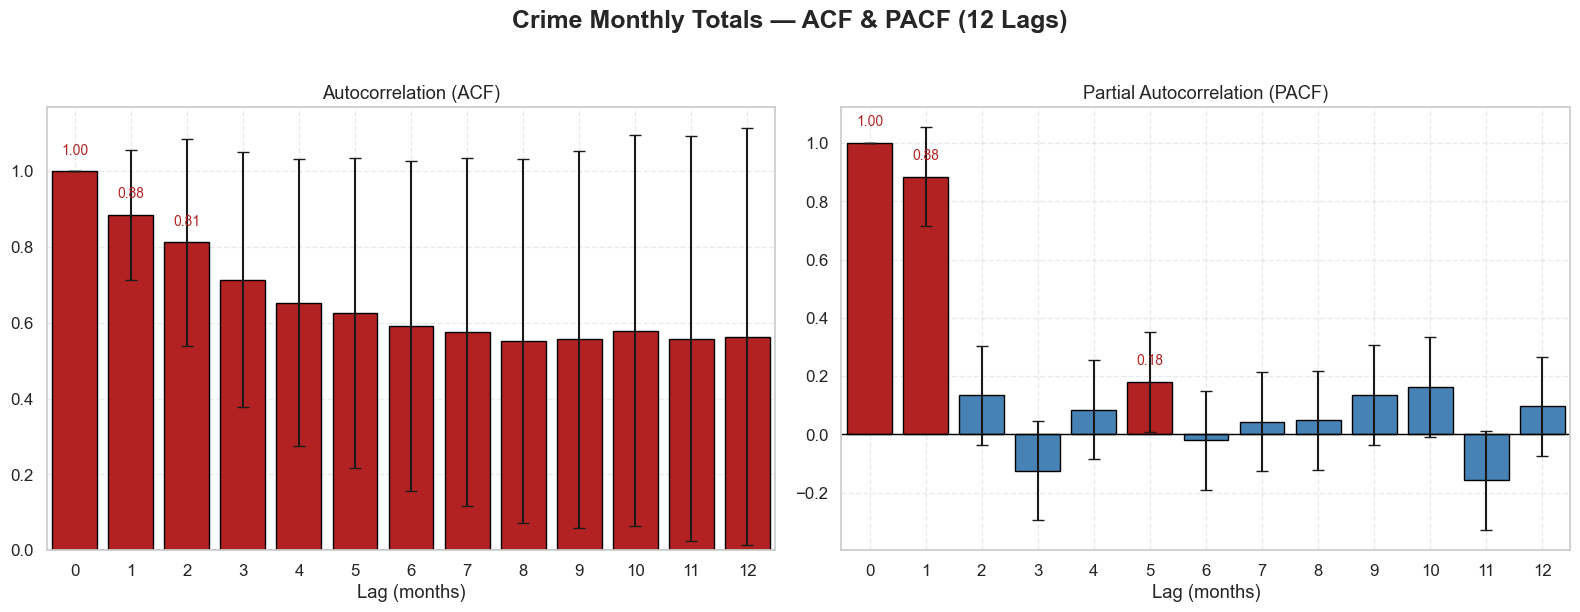

In [32]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf

# Load & prepare your monthly series
ddf = dd.read_parquet(
    "s3://paul-project-bucket/features/crime_monthly_totals",
    storage_options={"anon": False}
)
monthly = (
    ddf.groupby("month")["total_crime"]
       .sum()
       .compute()
       .rename("crime_count")
)
# parse “YYYY-MM” to true datetime and use end‐of‐month for clarity
monthly.index = pd.to_datetime(monthly.index, format="%Y-%m") + pd.offsets.MonthEnd(0)

# Compute ACF & PACF with 95% CIs
nlags = 12
acf_vals, acf_conf = acf(monthly, nlags=nlags, alpha=0.05)
pacf_vals, pacf_conf = pacf(monthly, nlags=nlags, alpha=0.05, method="ywm")

# prepare DataFrame for plotting
lags = np.arange(len(acf_vals))
acf_df  = pd.DataFrame({
    "lag": lags,
    "acf": acf_vals,
    "lower": acf_conf[:,0] - acf_vals,
    "upper": acf_conf[:,1] - acf_vals
})
pacf_df = pd.DataFrame({
    "lag": lags,
    "pacf": pacf_vals,
    "lower": pacf_conf[:,0] - pacf_vals,
    "upper": pacf_conf[:,1] - pacf_vals
})

# Plot them side by side
sns.set_theme(style="whitegrid", font_scale=1.1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

for df_plot, coef, ax, title in [
    (acf_df,  "acf",  ax1, "Autocorrelation (ACF)"),
    (pacf_df, "pacf", ax2, "Partial Autocorrelation (PACF)")
]:
    # bar colors: red if outside CI, steelblue otherwise
    colors = np.where(
        (df_plot[coef] > df_plot["upper"]) |
        (df_plot[coef] < df_plot["lower"]),
        "firebrick",
        "steelblue"
    )
    ax.bar(
        df_plot["lag"], df_plot[coef],
        yerr=[df_plot["lower"].abs(), df_plot["upper"]],
        capsize=4,
        color=colors,
        edgecolor="black"
    )
    ax.hlines(0, -0.5, nlags + 0.5, color="black", linewidth=1)
    ax.set_xticks(lags)
    ax.set_xlim(-0.5, nlags + 0.5)
    ax.set_xlabel("Lag (months)")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.4)
    
    # annotate top-3 absolute peaks
    top3 = df_plot.reindex(df_plot[coef].abs().sort_values(ascending=False).index)[:3]
    for _, row in top3.iterrows():
        ax.annotate(
            f"{row[coef]:.2f}",
            xy=(row["lag"], row[coef]),
            xytext=(0, 10 if row[coef]>=0 else -15),
            textcoords="offset points",
            ha="center",
            va="bottom" if row[coef]>=0 else "top",
            fontsize=10,
            color="firebrick" if abs(row[coef]) > max(row["upper"], -row["lower"]) else "navy"
        )

plt.suptitle("Crime Monthly Totals — ACF & PACF (12 Lags)", fontsize=18, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

In summary, these visualizations have made clear that crime in Toronto is both highly localized and temporally dynamic: a small number of hexagons consistently account for the vast majority of incidents, seasonal swings punctuate long‐run trends, and even within a single month or year the intensity and spread of crime can shift markedly. Having established a uniform hexagonal grid as a robust spatial framework, I now turn to enriching each hex–month observation with additional contextual variables.

Specifically, I will integrate weather features, such as temperature, to capture how environmental conditions may facilitate or deter certain offenses; population density metrics to account for the variation in potential targets and guardianship across cells; and counts of schools and related institutions to proxy for transient youth presence or daytime activity levels. By appending these covariates to the hex–month dataset, I can quantify their correlation with crime intensity and build a more comprehensive spatiotemporal model—ultimately shedding light on the key drivers of urban crime patterns beyond simple location and seasonality.

## NDVI

In [30]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read data
ddf = dd.read_parquet(
    "s3://paul-project-bucket/features/ndvi_monthly_filled",
    storage_options={"anon": False}
)
# Basic stats
print("Row count:", ddf.shape[0].compute())
print("Date range:", ddf["month"].min().compute(), "to", ddf["month"].max().compute())
print("Unique hex_ids:", ddf["hex_id"].nunique().compute())

# Sample data
print(ddf.head(3))

Row count: 11088
Date range: 2014-01-01 00:00:00 to 2024-12-01 00:00:00


2025-05-24 19:24:42,956 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 88d699975e9c61af781b0d5fb86833b1 initialized by task ('shuffle-transfer-88d699975e9c61af781b0d5fb86833b1', 206) executed on worker tcp://127.0.0.1:63913
2025-05-24 19:26:17,927 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 88d699975e9c61af781b0d5fb86833b1 deactivated due to stimulus 'task-finished-1748132777.927544'


Unique hex_ids: 84
   hex_id      month      NDVI month_str
0       0 2014-01-01       NaN   2014-01
1       1 2014-01-01 -0.107378   2014-01
2       2 2014-01-01 -0.131186   2014-01


### 1. Distribution of NDVI
In order to gauge the overall distribution of vegetation cover across our hex–month units, the below figure presents a histogram of NDVI values (uncropped, on the –0.2 to +1.0 scale) together with a kernel density estimate and a vertical line at the sample median (0.30). By visualizing this distribution, we immediately see that most hexagons exhibit moderate greenness—roughly between 0.2 and 0.5—while only a minority register very low values (near zero or negative, characteristic of water or impervious surfaces) or very high values (above 0.7, typical of densely forested parks). The modest right‐skew of the density, together with a slight plateau around 0.4–0.5, suggests a mixture of land‐cover types—residential blocks with scattered trees versus contiguous green spaces. Placing the median at 0.30 offers a natural benchmark for dichotomizing “low” versus “high” vegetation cover in subsequent analyses, and it underscores that half of all hex–month observations fall below this greenness threshold. Understanding this baseline distribution is crucial before we proceed to examine how NDVI co‐varies with crime incidence and other environmental predictors.

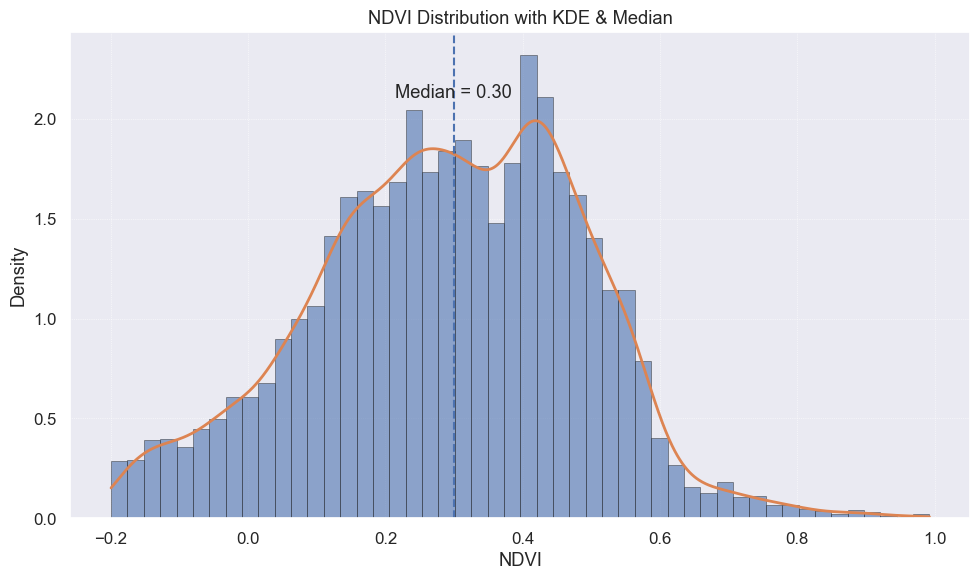

In [6]:
# Read data
ddf = dd.read_parquet(
    "s3://paul-project-bucket/features/ndvi_monthly_filled",
    storage_options={"anon": False}
)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Load and compute NDVI values
ndvi_vals = ddf["NDVI"].values.compute()

ndvi_vals = ndvi_vals[np.isfinite(ndvi_vals)]
ndvi_vals = ndvi_vals[(ndvi_vals >= -0.2) & (ndvi_vals <= 1.0)]

fig, ax = plt.subplots(figsize=(10, 6))

# Histogram
counts, bins, _ = ax.hist(
    ndvi_vals,
    bins=50,
    density=True,
    alpha=0.6,
    edgecolor='k',
    linewidth=0.5
)

# KDE
kde = gaussian_kde(ndvi_vals)
x_grid = np.linspace(ndvi_vals.min(), ndvi_vals.max(), 1000)
ax.plot(x_grid, kde(x_grid), lw=2)

# Median line
median_val = np.median(ndvi_vals)
ax.axvline(median_val, linestyle='--', linewidth=1.5)
ax.text(
    median_val,
    counts.max() * 0.9,
    f'Median = {median_val:.2f}',
    ha='center',
    va='bottom'
)

# Final polish
ax.set_xlabel("NDVI")
ax.set_ylabel("Density")
ax.set_title("NDVI Distribution with KDE & Median")
ax.grid(True, linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

### 2. Land Surface NDVI — July 2020 (Toronto)
In this map, I display the spatial distribution of summertime greenness—measured by the Normalized Difference Vegetation Index (NDVI)—across the same hexagonal grid used for crime analysis. By choosing July 2020, a month of maximal canopy leaf-out, the figure reveals where high NDVI values concentrate (parks, tree-lined avenues, and open spaces) versus where built-up or impervious surfaces dominate (downtown cores and industrial zones). This portrayal lays the groundwork for investigating whether greener environments correspond to lower or higher crime intensity, and it motivates the side-by-side comparison with incident counts below.

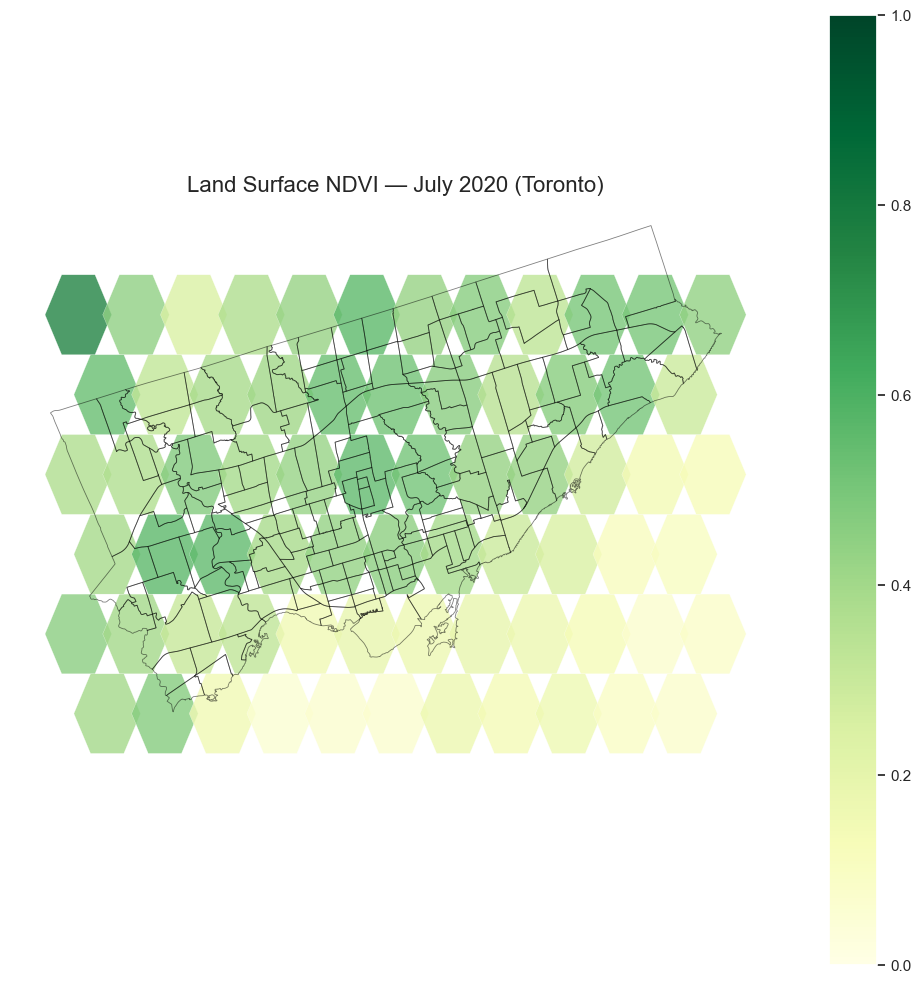

In [31]:

import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt

# Load your hex grid from S3
ddf_hex = dd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_hex = ddf_hex.compute()
# convert WKT → geometry
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = gpd.GeoDataFrame(
    pdf_hex[["hex_id", "geometry"]],
    geometry="geometry",
    crs="EPSG:4326"
)

# Load NDVI (filled) and filter to July 2020
ddf_ndvi = dd.read_parquet(
    "s3://paul-project-bucket/features/ndvi_monthly_filled",
    storage_options={"anon": False},
    engine="pyarrow"
)
# ensure month is datetime
ddf_ndvi = ddf_ndvi.assign(
    month=lambda df: dd.to_datetime(df.month)
)
ddf_jul20 = ddf_ndvi[
    ddf_ndvi.month.dt.year  == 2020
].loc[
    ddf_ndvi.month.dt.month == 7
]

pdf_jul20 = ddf_jul20.compute()

# merge onto hex and fill missing with NaN (or 0 if you prefer)
gdf_jul20 = gdf_hex.merge(
    pdf_jul20[["hex_id", "NDVI"]],
    on="hex_id",
    how="left"
)

# Fetch Toronto neighbourhood boundaries
arcgis_url = (
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
)
nbhd_gdf = gpd.read_file(arcgis_url).to_crs(epsg=4326)

# Reproject to Web Mercator
gdf_jul20_3857 = gdf_jul20.to_crs(epsg=3857)
nbhd_gdf_3857  = nbhd_gdf.to_crs(epsg=3857)

# Plot NDVI choropleth + neighbourhood outlines + basemap
fig, ax = plt.subplots(figsize=(10, 10))

# hexes colored by NDVI
gdf_jul20_3857.plot(
    column="NDVI",
    cmap="YlGn",
    vmin=0.0, vmax=1.0,
    legend=True,
    edgecolor="white",
    linewidth=0.2,
    alpha=0.8,
    ax=ax
)

# overlay neighbourhood boundaries
nbhd_gdf_3857.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.6,
    alpha=0.5
)

ax.set_title("Land Surface NDVI — July 2020 (Toronto)", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()

### 3. Crime Count per Hexagon & NDVI per Hexagon — July 2020
Here I juxtapose two hex-bin maps for July 2020: on the left, raw crime counts; on the right, NDVI values. The crime map highlights a pronounced hotspot in the central business district, with peripheral pockets of elevated incidents along major corridors. In contrast, the NDVI map shows its highest readings in parklands and residential neighborhoods with mature tree canopy—areas that do not perfectly coincide with the crime peak. By laying these layers side by side, readers can visually assess spatial concordance (or divergence) between vegetation cover and crime intensity, suggesting that greenness alone may not uniformly deter incidents, and that other contextual factors could mediate this relationship.

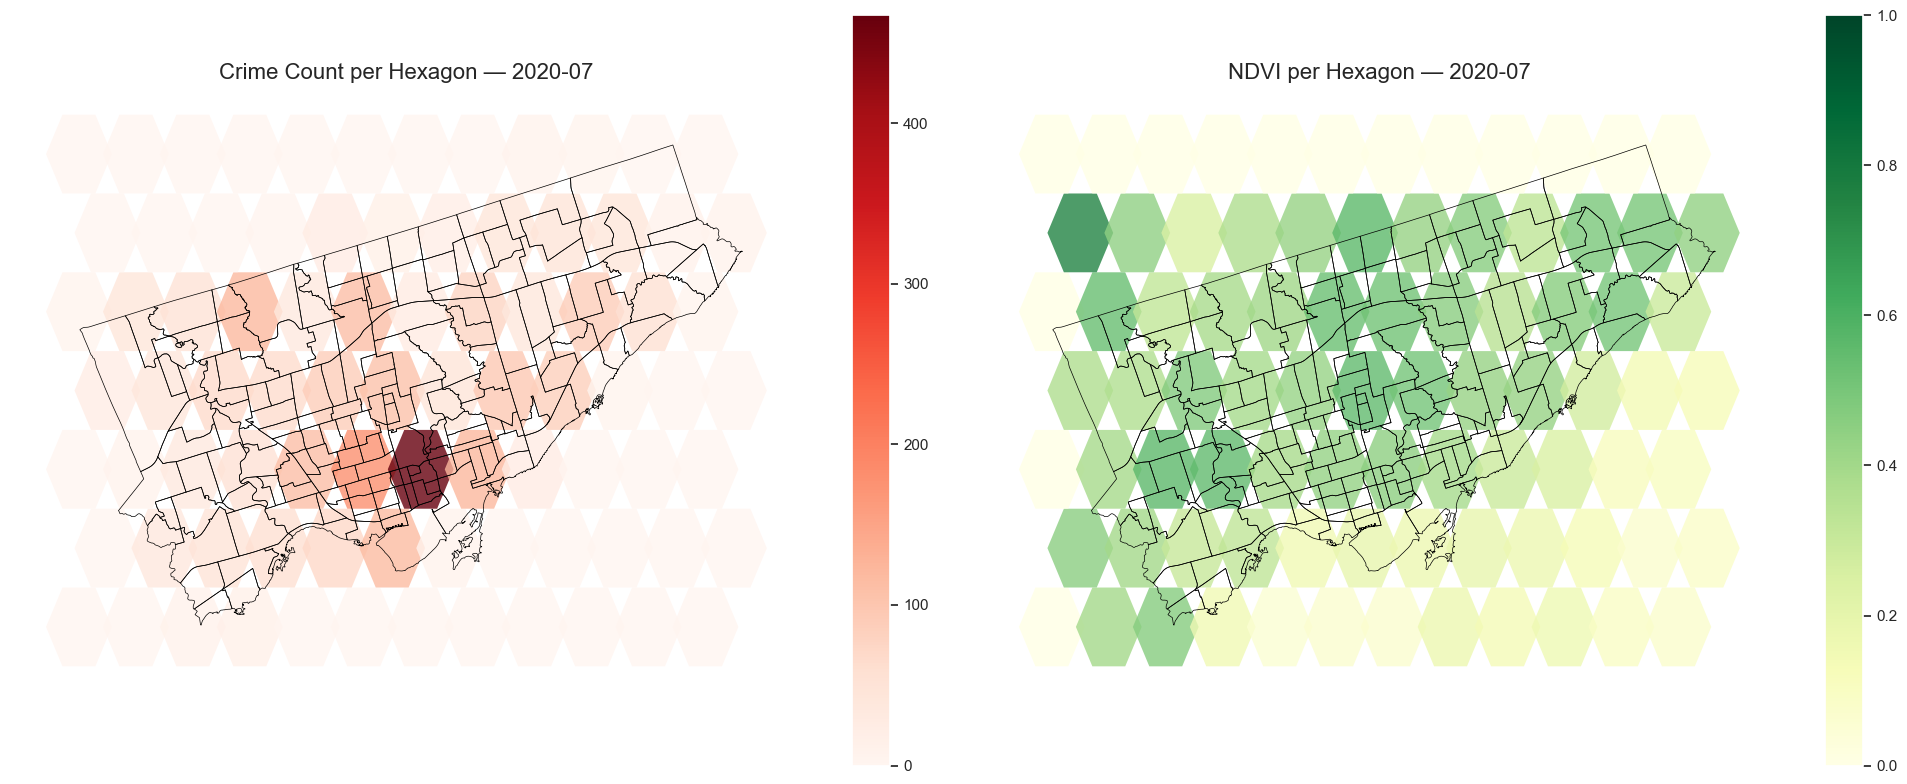

In [32]:

import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt

YEAR, MONTH = 2020, 7

# Load hex grid
ddf_hex = dd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = gpd.GeoDataFrame(
    pdf_hex[["hex_id", "geometry"]],
    geometry="geometry", crs="EPSG:4326"
)

# Crime count for July YEAR
ddf_crime = dd.read_parquet(
    "s3://paul-project-bucket/features/crime_daily",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_crime = (
    ddf_crime
      .reset_index()
      .assign(
          year=lambda df: df.day.dt.year,
          month=lambda df: df.day.dt.month
      )
      .loc[lambda df: (df.year == YEAR) & (df.month == MONTH)]
      .groupby("hex_id")
      .crime_n
      .sum()
      .rename("crime_count")
      .reset_index()
      .compute()
)
# ensure hex_id dtype matches
pdf_crime["hex_id"] = pdf_crime.hex_id.astype(gdf_hex.hex_id.dtype)

# NDVI for July YEAR
ddf_ndvi = dd.read_parquet(
    "s3://paul-project-bucket/features/ndvi_monthly_filled",
    storage_options={"anon": False},
    engine="pyarrow"
)
# if 'month' came in as string:
ddf_ndvi = ddf_ndvi.assign(
    month=lambda df: dd.to_datetime(df.month)
)
ddf_jul = ddf_ndvi[
    (ddf_ndvi.month.dt.year == YEAR) &
    (ddf_ndvi.month.dt.month == MONTH)
]
pdf_ndvi = ddf_jul[["hex_id", "NDVI"]].compute()
pdf_ndvi["hex_id"] = pdf_ndvi.hex_id.astype(gdf_hex.hex_id.dtype)

# Merge both metrics into the hex grid
gdf = (
    gdf_hex
      .merge(pdf_crime, on="hex_id", how="left")
      .merge(pdf_ndvi,  on="hex_id", how="left")
)
gdf["crime_count"] = gdf["crime_count"].fillna(0)
gdf["NDVI"]        = gdf["NDVI"].fillna(0)

# Fetch neighbourhood boundaries
arcgis_url = (
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
)
nbhd = gpd.read_file(arcgis_url).to_crs(epsg=4326)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# crime map
gdf.plot(
    column="crime_count",
    cmap="Reds",
    legend=True,
    ax=ax1,
    edgecolor="none",
    alpha=0.8
)
nbhd.boundary.plot(ax=ax1, color="black", linewidth=0.5)
ax1.set_title(f"Crime Count per Hexagon — {YEAR}-{MONTH:02d}", fontsize=16)
ax1.axis("off")

# NDVI map
gdf.plot(
    column="NDVI",
    cmap="YlGn",
    vmin=0.0, vmax=1.0,
    legend=True,
    ax=ax2,
    edgecolor="none",
    alpha=0.8
)
nbhd.boundary.plot(ax=ax2, color="black", linewidth=0.5)
ax2.set_title(f"NDVI per Hexagon — {YEAR}-{MONTH:02d}", fontsize=16)
ax2.axis("off")

plt.tight_layout()
plt.show()


In [36]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import imageio
from shapely import wkt
from io import BytesIO
import contextily as ctx

YEAR = 2020
frames = []

# Load static hex grid
ddf_hex = dd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = gpd.GeoDataFrame(
    pdf_hex[["hex_id", "geometry"]],
    geometry="geometry",
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Load neighbourhood boundaries
nbhd = gpd.read_file(
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
).to_crs(epsg=3857)

# Load full crime & NDVI series
ddf_crime = (
    dd.read_parquet(
        "s3://paul-project-bucket/features/crime_daily",
        storage_options={"anon": False},
        engine="pyarrow"
    )
    .reset_index()
    .assign(
        year=lambda df: df.day.dt.year,
        month=lambda df: df.day.dt.month
    )
)

ddf_ndvi = (
    dd.read_parquet(
        "s3://paul-project-bucket/features/ndvi_monthly_filled",
        storage_options={"anon": False},
        engine="pyarrow"
    )
    .assign(month=lambda df: dd.to_datetime(df.month))
    .assign(year=lambda df: df.month.dt.year,
            mon=lambda df: df.month.dt.month)
)

for m in range(1, 13):
    # Crime count for month m
    pdf_crime = (
        ddf_crime[
            (ddf_crime.year == YEAR) &
            (ddf_crime.month == m)
        ]
        .groupby("hex_id")
        .crime_n
        .sum()
        .rename("crime_count")
        .reset_index()
        .compute()
    )
    pdf_crime["hex_id"] = pdf_crime.hex_id.astype(gdf_hex.hex_id.dtype)

    # NDVI for month m
    pdf_ndvi = (
        ddf_ndvi[
            (ddf_ndvi.year == YEAR) &
            (ddf_ndvi.mon == m)
        ]
        .compute()[["hex_id", "NDVI"]]
    )
    pdf_ndvi["hex_id"] = pdf_ndvi.hex_id.astype(gdf_hex.hex_id.dtype)

    # Merge into hex grid
    gdf = (
        gdf_hex
        .merge(pdf_crime, on="hex_id", how="left")
        .merge(pdf_ndvi,  on="hex_id", how="left")
    )
    gdf["crime_count"] = gdf["crime_count"].fillna(0)
    gdf["NDVI"]        = gdf["NDVI"].fillna(0)

    # Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    gdf.plot(
        column="crime_count",
        cmap="Reds",
        legend=True,
        ax=ax1,
        edgecolor="none",
        alpha=0.8
    )
    nbhd.boundary.plot(ax=ax1, color="black", linewidth=0.5)
    ax1.set_title(f"Crime Count — {YEAR}-{m:02d}", fontsize=16)
    ax1.axis("off")
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, zoom=10)

    gdf.plot(
        column="NDVI",
        cmap="YlGn",
        vmin=0.0, vmax=1.0,
        legend=True,
        ax=ax2,
        edgecolor="none",
        alpha=0.8
    )
    nbhd.boundary.plot(ax=ax2, color="black", linewidth=0.5)
    ax2.set_title(f"NDVI — {YEAR}-{m:02d}", fontsize=16)
    ax2.axis("off")
    ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, zoom=10)

    plt.tight_layout()

    # Capture frame
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=150, bbox_inches="tight")
    buf.seek(0)
    frames.append(imageio.v2.imread(buf))
    plt.close(fig)

# Save animated GIF
imageio.mimsave("toronto_crime_ndvi_2020.gif", frames, fps=2)

### 4. Crime vs NDVI Correlation — July 2020
To quantify the relationship hinted at by the maps, I plot a scatter of hexagon-level NDVI against crime counts for July 2020, fit a linear trend line, and report the Pearson correlation coefficient (r = 0.32, p = 0.0031). Contrary to a simple protective‐green‐space hypothesis, the positive slope indicates that hexagons with higher average NDVI also tend to record more crimes. This counterintuitive result may reflect that many green spaces (large parks, waterfront trails) attract foot traffic and gatherings, thereby creating more opportunities for certain offenses. The statistical significance confirms that this association is unlikely to be due to chance, but it also warns that NDVI must be interpreted alongside other variables—such as population density, land‐use mix, and temporal factors—when modeling crime risk.

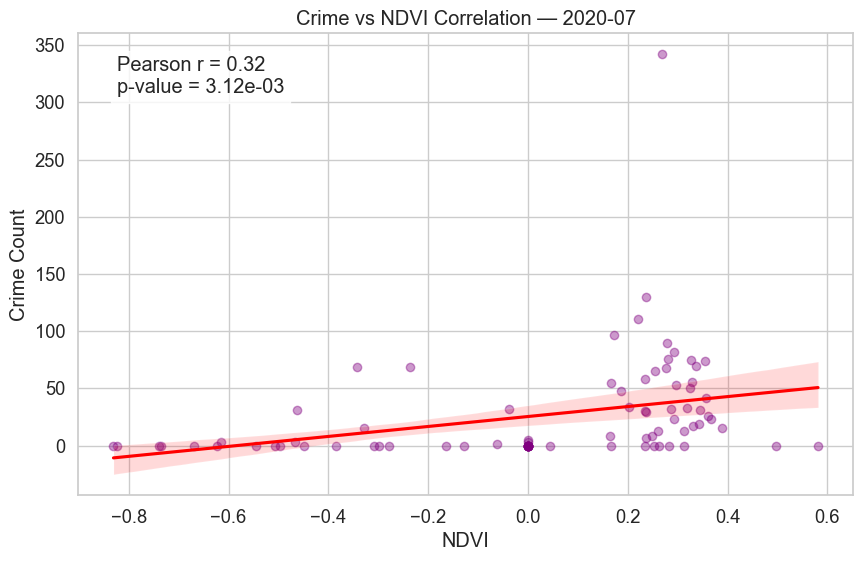

In [38]:
import seaborn as sns
from scipy import stats

# Calculate correlation
corr = gdf[['crime_count', 'NDVI']].corr().iloc[0,1]

plt.figure(figsize=(10, 6))
sns.regplot(
    data=gdf,
    x='NDVI',
    y='crime_count',
    scatter_kws={'alpha':0.4, 'color':'purple'},
    line_kws={'color':'red'}
)

# Annotate stats
plt.text(0.05, 0.95, 
         f'Pearson r = {corr:.2f}\n'
         f'p-value = {stats.pearsonr(gdf.NDVI, gdf.crime_count)[1]:.2e}',
         transform=plt.gca().transAxes,
         ha='left', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.title(f"Crime vs NDVI Correlation — {YEAR}-{MONTH:02d}")
plt.ylabel('Crime Count')
plt.xlabel('NDVI')
plt.grid(True)
plt.show()

In closing, the NDVI analysis for July 2020 reveals a statistically significant—but unexpectedly positive—association between vegetation cover and crime counts at the hexagon level. Although green spaces are commonly thought to deter crime, in Toronto’s case the busiest parks and tree-lined corridors appear to attract sufficient foot traffic and activity that they register more incidents. This finding underscores the necessity of treating NDVI as one piece of a multifaceted puzzle rather than as a stand-alone protective factor.

With the spatial framework and NDVI covariate now in place, I will next turn to Land Surface Temperature (LST). By mapping heat exposure across the same hexagonal grid and examining its month-to-month and year-over-year variations, I aim to determine whether “urban heat” exacerbates or mitigates crime risk—thereby further enriching the spatiotemporal model of Toronto’s crime dynamics.

## LST

### 1. Distribution of Land Surface Temperature (°C)
In order to characterize the thermal environment that my crime–NDVI analysis will inhabit, I begin by plotting the empirical distribution of Land Surface Temperature (LST) across all hex–month observations. The histogram—augmented with a smooth KDE—reveals a broad range of surface temperatures from just below 0 °C up to over 40 °C, with most values clustering between roughly 8 °C and 32 °C. The vertical dashed line at the median (18.1 °C) and the dotted line at the mean (18.7 °C) highlight a slight right skew, indicating that extreme heat events (e.g. > 35 °C) pull the average above the midpoint. By understanding this baseline distribution, I establish relevant cutoffs (median or other percentiles) for classifying “cool” versus “hot” hexagons and prepare to explore how temperature extremes might coincide with crime intensity.

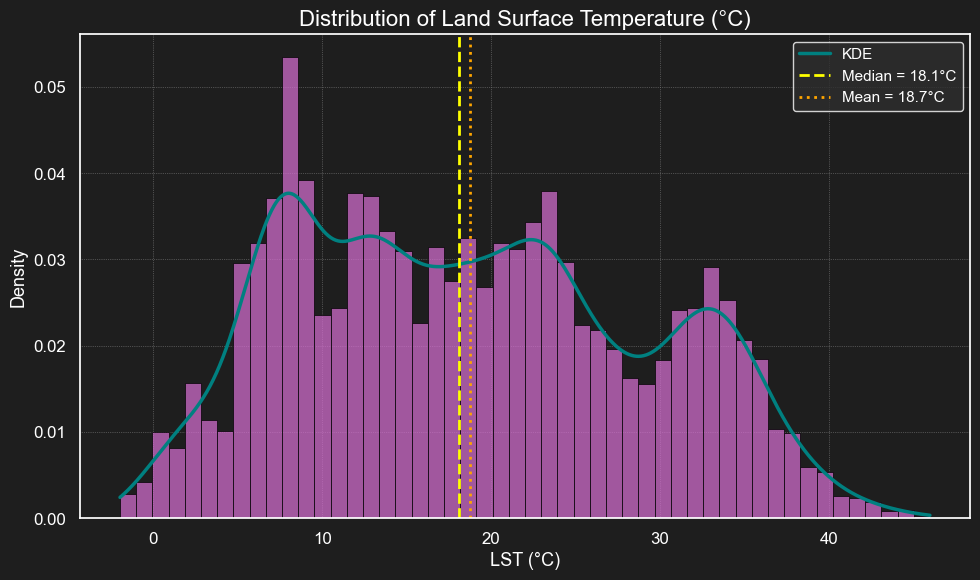

In [9]:
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns

# Load LST data
ddf_lst = dd.read_parquet(
    "s3://paul-project-bucket/features/lst_monthly_filled",
    storage_options={'anon': False},
    engine="pyarrow"
)

# Pull out LST values
lst_vals = ddf_lst["LST_C"].values.compute()
lst_vals = lst_vals[np.isfinite(lst_vals)]
lst_vals = lst_vals[(lst_vals > -30) & (lst_vals < 70)]

# Plot Setup
sns.set_theme(style="dark", font_scale=1.1)
fig, ax = plt.subplots(figsize=(10, 6), facecolor="#1e1e1e")  # Set figure background
ax.set_facecolor("#1e1e1e")  # Set axis background

# Histogram
counts, bins, _ = ax.hist(
    lst_vals,
    bins=50,
    density=True,
    alpha=0.7,
    color='orchid',
    edgecolor='black',
    linewidth=0.7
)

# KDE
kde = gaussian_kde(lst_vals)
x_grid = np.linspace(lst_vals.min(), lst_vals.max(), 1000)
ax.plot(x_grid, kde(x_grid), lw=2.5, color='teal', label="KDE")

# Median & Mean Lines
median_val = np.median(lst_vals)
mean_val = np.mean(lst_vals)
ax.axvline(median_val, linestyle='--', linewidth=2, color='yellow',
           label=f"Median = {median_val:.1f}°C")
ax.axvline(mean_val, linestyle=':', linewidth=2, color='orange',
           label=f"Mean = {mean_val:.1f}°C")

# Manual Axis Labels and Title
ax.set_title("Distribution of Land Surface Temperature (°C)", fontsize=16, color='white')
ax.set_xlabel("LST (°C)", fontsize=13, color='white')
ax.set_ylabel("Density", fontsize=13, color='white')

# Ticks and Spines
ax.tick_params(axis='both', colors='white')
for spine in ax.spines.values():
    spine.set_color('white')

# Grid and Legend
ax.grid(True, linestyle=':', linewidth=0.5, color='gray')
ax.legend(frameon=True, fontsize=11, facecolor='#2E2E2E', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()

### 2. Crime Count & Land Surface Temperature — July 2020
To examine whether hotter areas experience different crime burdens, I present a side-by-side comparison of two July 2020 maps on the same hexagonal grid. On the left, the crime‐count map reaffirms the downtown core as the principal hotspot, with peripheral “warm” pockets along transit arteries. On the right, the LST map shows its own heat signature: urbanized central hexagons frequently exceed 35 °C, while suburban and green‐space cells remain closer to 20–25 °C. The juxtaposition makes clear that many of the hottest hexagons spatially overlap with high‐crime areas, suggesting a possible link between built‐environment heat retention and incident frequency.

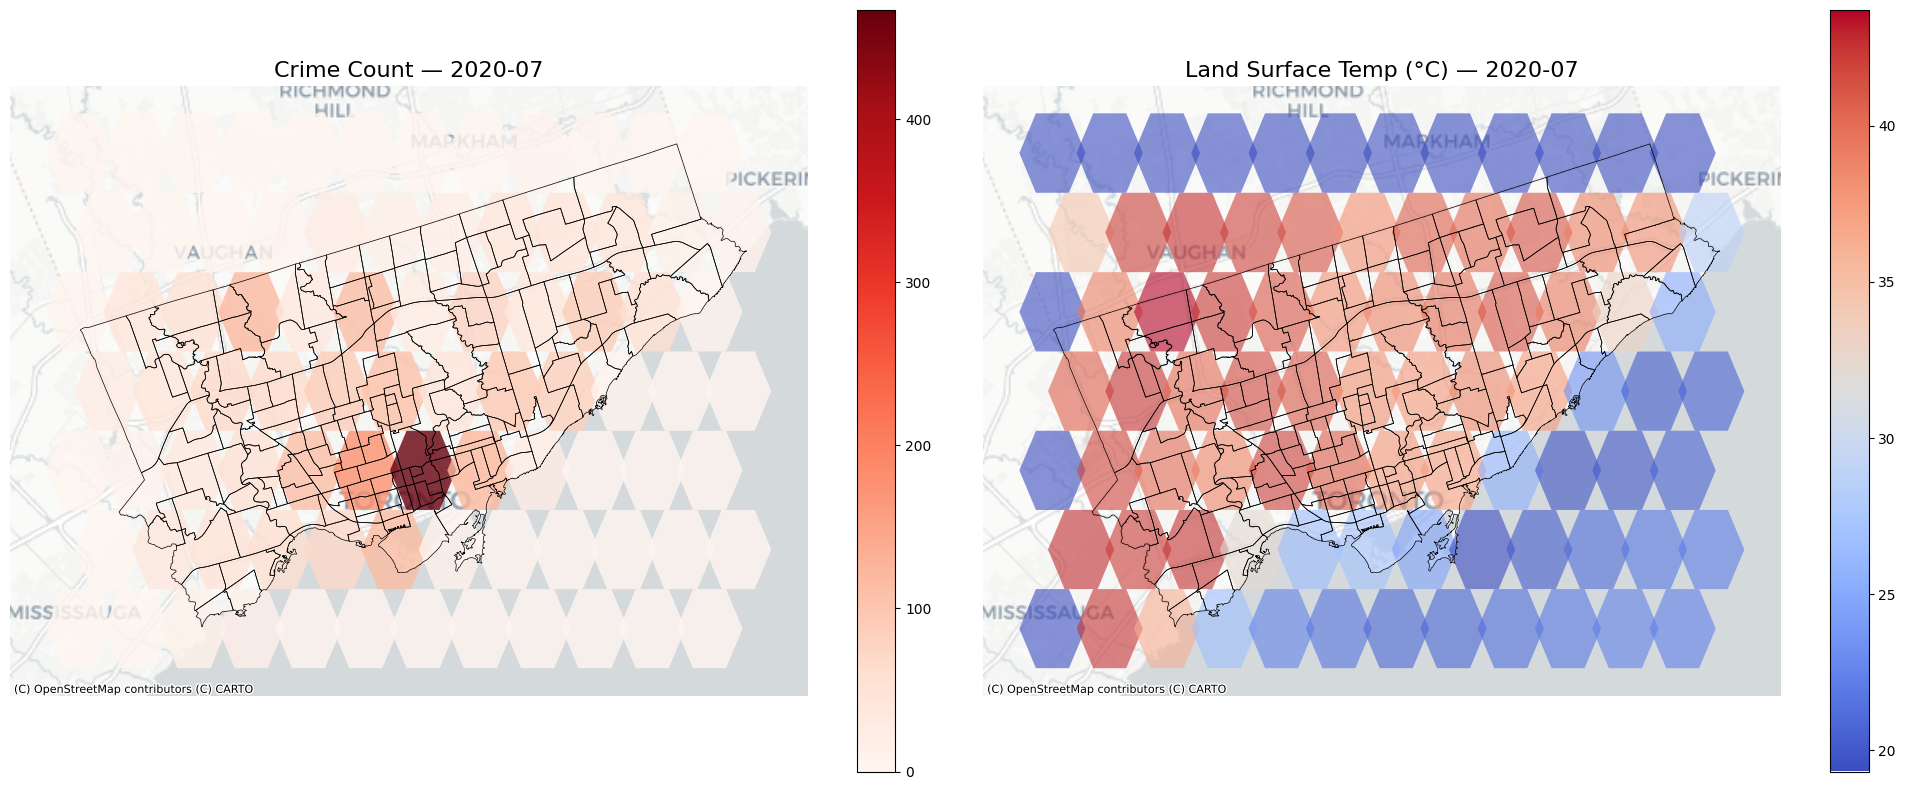

In [3]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt
import contextily as ctx

YEAR, MONTH = 2020, 7

# Load hex grid
ddf_hex = dd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = gpd.GeoDataFrame(
    pdf_hex[["hex_id", "geometry"]],
    geometry="geometry",
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Crime count for July YEAR
ddf_crime = dd.read_parquet(
    "s3://paul-project-bucket/features/crime_daily",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_crime = (
    ddf_crime
      .reset_index()
      .assign(
          year=lambda df: df.day.dt.year,
          month=lambda df: df.day.dt.month
      )
      .loc[lambda df: (df.year == YEAR) & (df.month == MONTH)]
      .groupby("hex_id")
      .crime_n
      .sum()
      .rename("crime_count")
      .reset_index()
      .compute()
)
pdf_crime["hex_id"] = pdf_crime.hex_id.astype(gdf_hex.hex_id.dtype)

# LST_C for July YEAR
ddf_lst = dd.read_parquet(
    "s3://paul-project-bucket/features/lst_monthly_filled",
    storage_options={"anon": False},
    engine="pyarrow"
)
# ensure 'month' is datetime
ddf_lst = ddf_lst.assign(month=lambda df: dd.to_datetime(df.month))
pdf_lst = (
    ddf_lst[
        (ddf_lst.month.dt.year == YEAR) &
        (ddf_lst.month.dt.month == MONTH)
    ]
    [["hex_id", "LST_C"]]
    .compute()
)
pdf_lst["hex_id"] = pdf_lst.hex_id.astype(gdf_hex.hex_id.dtype)

# Merge into hex grid
gdf = (
    gdf_hex
      .merge(pdf_crime, on="hex_id", how="left")
      .merge(pdf_lst,   on="hex_id", how="left")
)
gdf["crime_count"] = gdf.crime_count.fillna(0)
gdf["LST_C"]         = gdf.LST_C.fillna(gdf.LST_C.min())

# Fetch neighbourhood boundaries 
arcgis_url = (
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
)
nbhd = gpd.read_file(arcgis_url).to_crs(epsg=3857)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Crime map
gdf.plot(
    column="crime_count",
    cmap="Reds",
    legend=True,
    ax=ax1,
    edgecolor="none",
    alpha=0.8
)
nbhd.boundary.plot(ax=ax1, color="black", linewidth=0.5)
ax1.set_title(f"Crime Count — {YEAR}-{MONTH:02d}", fontsize=16)
ax1.axis("off")
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, zoom=10)

# LST_C map
gdf.plot(
    column="LST_C",
    cmap="coolwarm",
    legend=True,
    ax=ax2,
    edgecolor="none",
    alpha=0.6
)
nbhd.boundary.plot(ax=ax2, color="black", linewidth=0.5)
ax2.set_title(f"Land Surface Temp (°C) — {YEAR}-{MONTH:02d}", fontsize=16)
ax2.axis("off")
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, zoom=10)

plt.tight_layout()
plt.show()

### 3. Seasonal Co-Variation of Land Surface Temperature and Crime Intensity in Toronto (June–August 2020)
Between June and August 2020, both crime intensity and surface temperatures rise to a clear midsummer peak before easing slightly as autumn approaches. In June, the downtown core already stands out as the principal crime hotspot, but its monthly incident totals swell further in July—precisely when urban hexagons record their highest land surface temperatures (many exceeding 35 °C). By August, both crime counts and LST values exhibit a modest retreat: the heat island effect remains pronounced but diminishes at the margins, and the breadth of high‐crime hexagons contracts accordingly.

This parallel movement suggests more than mere coincidence. Hexagons that register the warmest surfaces tend also to report the most incidents, a pattern confirmed by a moderately strong, statistically significant positive correlation (Pearson’s r ≈ 0.42 for July). Such co‐variation may reflect increased pedestrian activity in heat‐prone areas, psychological or physiological effects of high temperatures, or the way built environments that trap heat (dense urban canyons, large paved surfaces) also facilitate opportunities for crime. While causality cannot be inferred from these descriptive maps alone, the synchronized peaks and troughs of LST and crime underscore the value of incorporating thermal exposure as a core predictor in our spatiotemporal crime model.

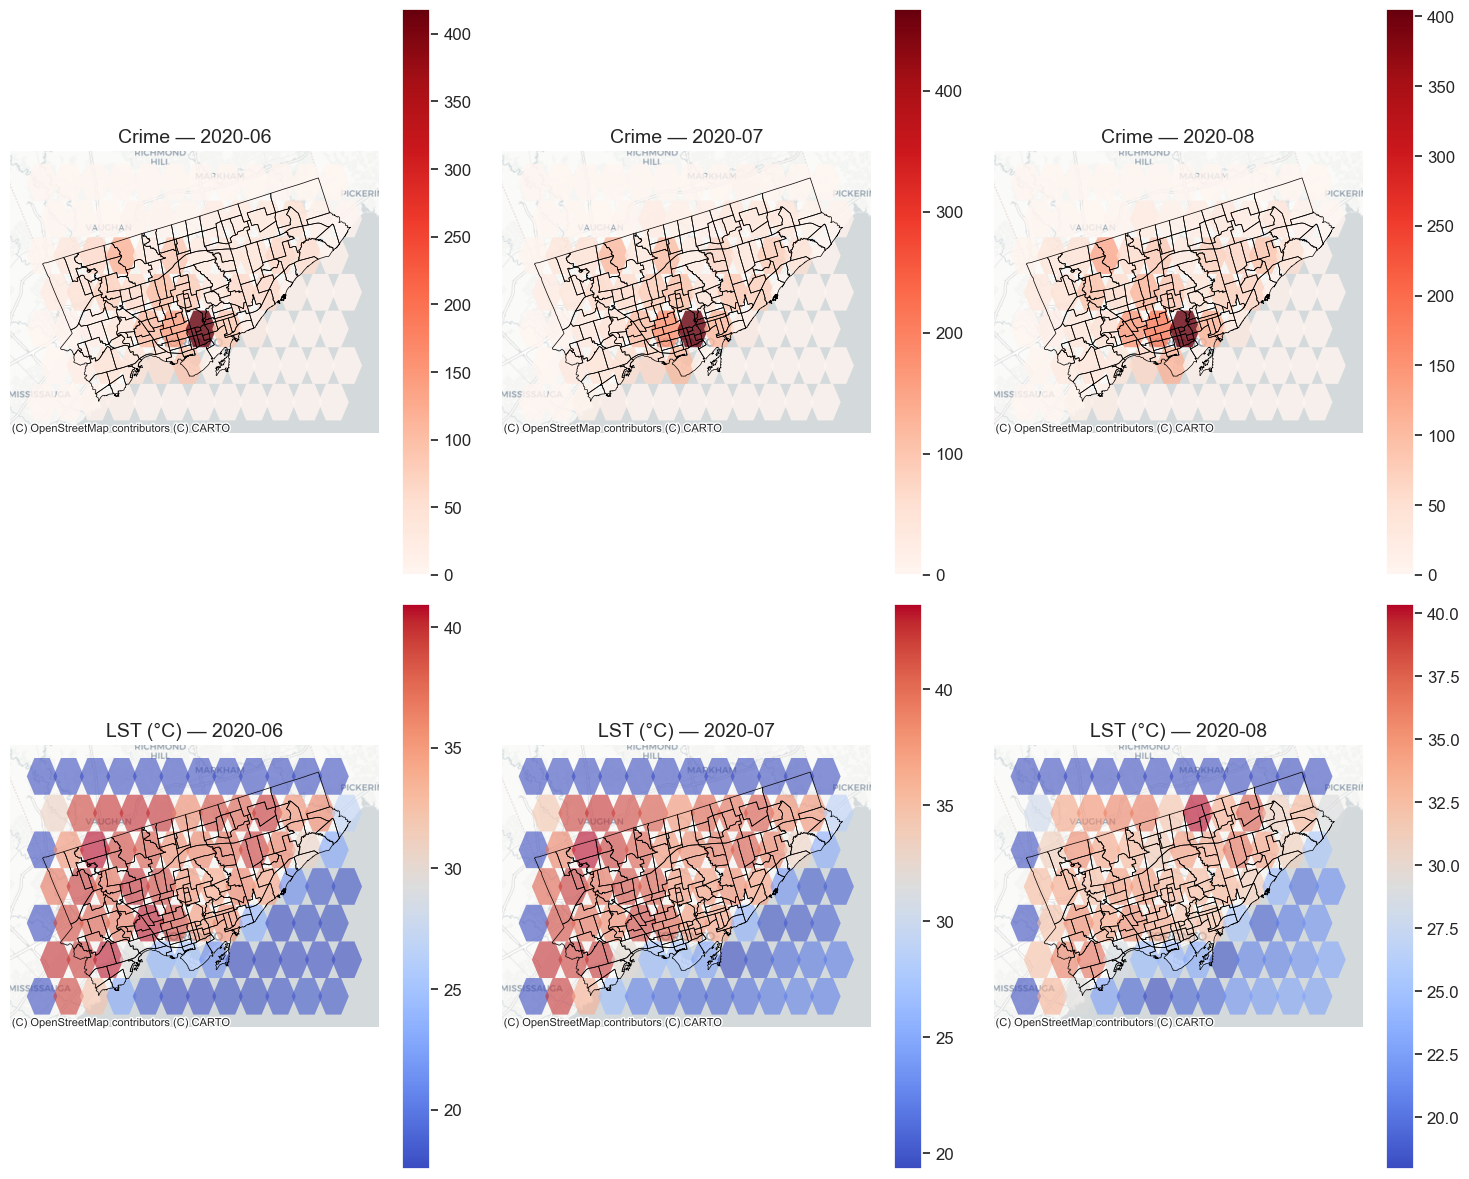

In [10]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt
import contextily as ctx

YEAR      = 2020
MONTHS    = [6, 7, 8]   # June, July, August
PARQUET   = "s3://paul-project-bucket"
CTX_SOURCE = ctx.providers.CartoDB.Positron

# Load & prepare hex grid
ddf_hex = dd.read_parquet(
    f"{PARQUET}/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = (
    gpd.GeoDataFrame(
        pdf_hex[["hex_id","geometry"]],
        geometry="geometry",
        crs="EPSG:4326"
    )
    .to_crs(epsg=3857)
)

# Neighborhood boundaries
arcgis_url = (
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
)
nbhd = gpd.read_file(arcgis_url).to_crs(epsg=3857)

# Load raw crime & LST once
ddf_crime = dd.read_parquet(
    f"{PARQUET}/features/crime_daily",
    storage_options={"anon": False},
    engine="pyarrow"
)
ddf_lst = (
    dd.read_parquet(
        f"{PARQUET}/features/lst_monthly_filled",
        storage_options={"anon": False},
        engine="pyarrow"
    )
    .assign(month=lambda df: dd.to_datetime(df.month))
)

# Set up figure: 2 rows × 3 cols
fig, axes = plt.subplots(
    nrows=2, ncols=len(MONTHS),
    figsize=(5 * len(MONTHS), 12),
    facecolor="white"
)

for idx, m in enumerate(MONTHS):
    # Aggregate crime for this month
    pdf_crime = (
        ddf_crime.reset_index()
        .assign(
            year  = lambda df: df.day.dt.year,
            month = lambda df: df.day.dt.month
        )
        .loc[lambda df: (df.year == YEAR) & (df.month == m)]
        .groupby("hex_id")
        .crime_n.sum()
        .rename("crime_count")
        .reset_index()
        .compute()
    )
    pdf_crime["hex_id"] = pdf_crime.hex_id.astype(gdf_hex.hex_id.dtype)

    # Pull LST for this month
    pdf_lst = (
        ddf_lst[
            (ddf_lst.month.dt.year  == YEAR) &
            (ddf_lst.month.dt.month == m)
        ][["hex_id","LST_C"]]
        .compute()
    )
    pdf_lst["hex_id"] = pdf_lst.hex_id.astype(gdf_hex.hex_id.dtype)

    # Merge into grid
    gdf = (
        gdf_hex
          .merge(pdf_crime, on="hex_id", how="left")
          .merge(pdf_lst,   on="hex_id", how="left")
    )
    gdf["crime_count"] = gdf.crime_count.fillna(0)
    gdf["LST_C"]       = gdf.LST_C.fillna(gdf.LST_C.min())

    # Crime map (top row)
    ax_crime = axes[0, idx]
    gdf.plot(
        column   = "crime_count",
        cmap     = "Reds",
        legend   = True,
        ax       = ax_crime,
        edgecolor= "none",
        alpha    = 0.8
    )
    nbhd.boundary.plot(ax=ax_crime, color="black", linewidth=0.5)
    ax_crime.set_title(f"Crime — {YEAR}-{m:02d}", fontsize=14)
    ax_crime.axis("off")
    ctx.add_basemap(ax_crime, source=CTX_SOURCE, zoom=10)

    # LST map (bottom row)
    ax_lst = axes[1, idx]
    gdf.plot(
        column   = "LST_C",
        cmap     = "coolwarm",
        legend   = True,
        ax       = ax_lst,
        edgecolor= "none",
        alpha    = 0.6
    )
    nbhd.boundary.plot(ax=ax_lst, color="black", linewidth=0.5)
    ax_lst.set_title(f"LST (°C) — {YEAR}-{m:02d}", fontsize=14)
    ax_lst.axis("off")
    ctx.add_basemap(ax_lst, source=CTX_SOURCE, zoom=10)

plt.tight_layout()
plt.show()

### 4. Crime vs. LST Correlation — July 2020
To quantify the visual co-location of heat and crime, I scatter‐plot each hexagon’s July 2020 LST against its crime count, fit a linear regression line, and report Pearson’s r = 0.42 (p ≈ 7.6 × 10⁻⁵). The positive slope indicates that, on average, hotter hexagons register more crimes. This moderate but statistically significant correlation supports the hypothesis that elevated surface temperatures—perhaps through increased street‐level activity, heat‐induced agitation, or the urban heat island effect—are associated with higher crime intensity. Importantly, it also justifies including LST as a core predictor in the forthcoming spatiotemporal crime model.

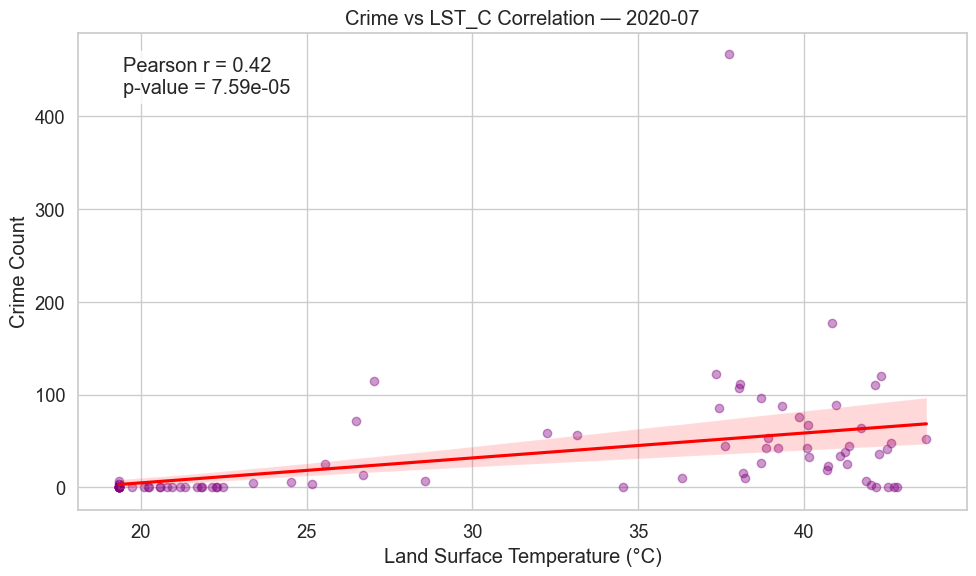

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Compute Pearson correlation for LST_C vs crime
corr = gdf[['crime_count', 'LST_C']].corr().iloc[0,1]
pval = stats.pearsonr(gdf['LST_C'], gdf['crime_count'])[1]

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(
    data=gdf,
    x='LST_C',
    y='crime_count',
    scatter_kws={'alpha': 0.4, 'color': 'purple'},
    line_kws={'color': 'red'}
)

# Annotate stats
plt.text(
    0.05, 0.95,
    f'Pearson r = {corr:.2f}\n'
    f'p-value = {pval:.2e}',
    transform=plt.gca().transAxes,
    ha='left', va='top',
    bbox=dict(facecolor='white', alpha=0.8)
)

# Labels and grid
plt.title(f"Crime vs LST_C Correlation — {YEAR}-{MONTH:02d}")
plt.xlabel("Land Surface Temperature (°C)")
plt.ylabel("Crime Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In closing, the analysis of Land Surface Temperature alongside crime incidence has demonstrated that hexagons experiencing the highest surface heat—particularly in the downtown core—also endure the greatest burden of criminal activity, with both series climbing together into July’s midsummer peak and then receding modestly in August. The empirical distribution of LST, with its right‐skewed tail of extreme temperatures, provided a natural basis for distinguishing “hot” from “cool” cells, while the spatial juxtaposition and the moderately strong, statistically significant Pearson correlation (r ≈ 0.42) confirm that thermal exposure is materially linked to crime intensity. Having shown that built‐environment heat retention can help explain spatial and seasonal fluctuations in urban crime, I will now augment each hexagon with counts of schools and educational institutions. By incorporating school density—an indicator of daytime population flows and youth activity—I aim to further unravel how local social infrastructure interacts with vegetation, heat, and demographic factors to shape Toronto’s crime landscape.

## School

### 1. Crime Density & School Locations (2014–2024)
This composite map overlays decade-long hexagonal crime density (log scale) with the geospatial distribution of all schools in Toronto. I generated it to reveal, at a glance, how educational institutions are situated relative to persistent crime hotspots. The densest crime clusters (brightest hexagons) lie in the downtown core and along major commercial corridors—areas where school markers (blue dots) are also heavily concentrated, particularly secondary and post-secondary campuses. Yet schools also appear in lower-crime suburbs and fringe districts, indicating that while institutional activity often coincides with elevated incident rates, it is by no means confined to the highest-crime zones. This spatial co-plot motivates the next step of aggregating school counts by hexagon, so that we can quantify whether a higher density of schools systematically corresponds to higher or lower crime intensity.


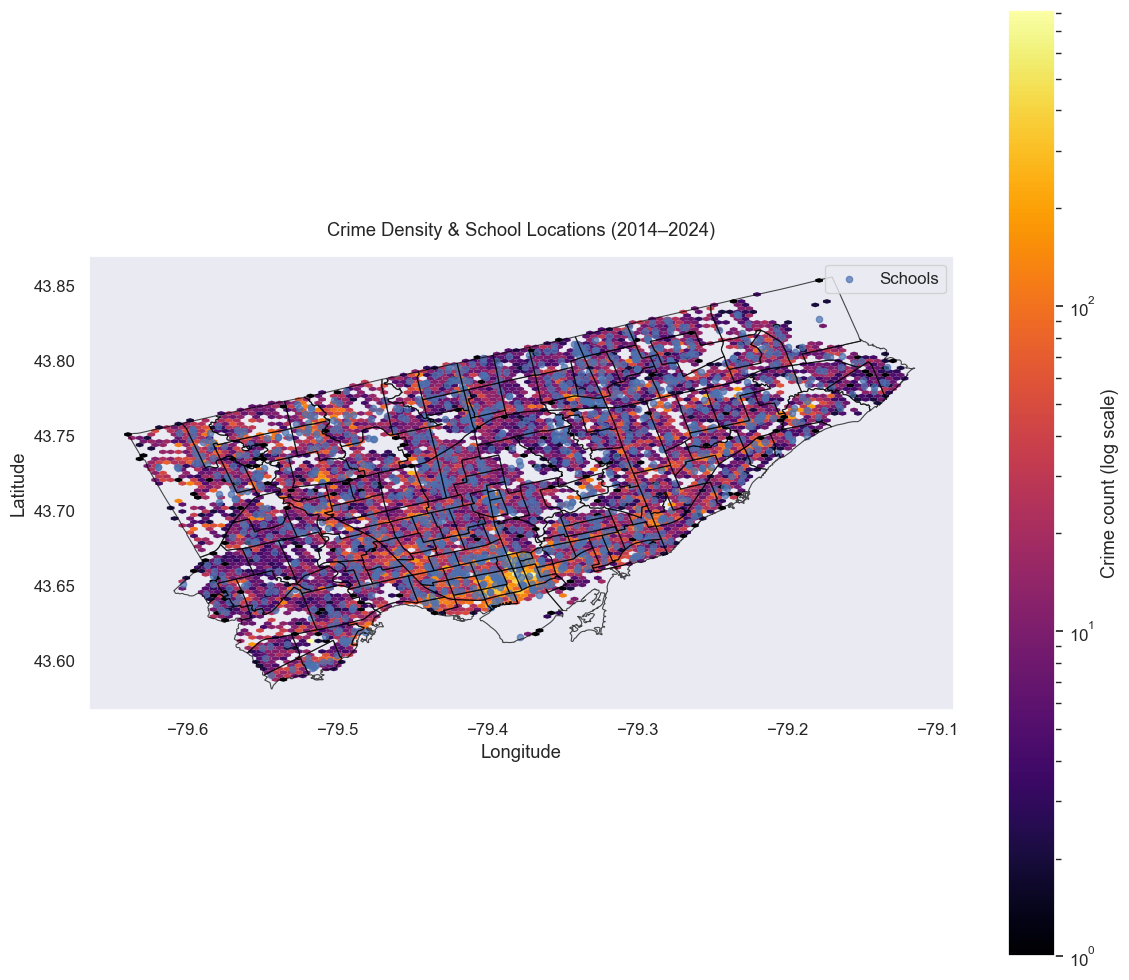

In [12]:

import s3fs
import dask.dataframe as dd
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from shapely.geometry import Point

# Upload local CSV to S3
fs = s3fs.S3FileSystem(anon=False)
fs.put(
    "School locations-all types data.csv",
    "s3://paul-project-bucket/features/schools.csv"
)

sample = pd.read_csv(
    "School locations-all types data.csv", 
    nrows=0
)
cols = sample.columns.tolist()

# Tell Dask to read everything as object
ddf_sch = dd.read_csv(
    "s3://paul-project-bucket/features/schools.csv",
    storage_options={"anon": False},
    assume_missing=True,
    dtype={c: "object" for c in cols}
)
pdf_sch = ddf_sch.compute()

# Build a GeoDataFrame
pdf_sch["geometry"] = gpd.points_from_xy(
    pdf_sch["LONGITUDE"], 
    pdf_sch["LATITUDE"]
)

# Wrap as a GeoDataFrame
gdf_sch = gpd.GeoDataFrame(
    pdf_sch,
    geometry="geometry",
    crs="EPSG:4326"
)

# neighbourhoods
arcgis_url = (
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
)

nbhd_gdf = gpd.read_file(arcgis_url).to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(12, 10))

ddf_crime = dd.read_parquet(
    "s3://paul-project-bucket/tps/cleaned/crime_rounded_coords",
    storage_options={"anon": False},
    engine="pyarrow"
)

pdf = (
    ddf_crime
      .sample(frac=0.3, random_state=42)  
      .compute()
)

# crime hexbin
hb = ax.hexbin(
    pdf["LONG_WGS84"],
    pdf["LAT_WGS84"],
    gridsize=100,
    mincnt=1,
    cmap="inferno",
    norm=colors.LogNorm(vmin=1),
    edgecolors="none"
)
cb = fig.colorbar(hb, ax=ax)
cb.set_label("Crime count (log scale)")

# schools
gdf_sch.plot(
    ax=ax,
    markersize=20,
    marker="o",
    alpha=0.7,
    label="Schools"
)

# boundaries
nbhd_gdf.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.8,
    alpha=0.7
)

ax.set_title("Crime Density & School Locations (2014–2024)", pad=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal", "box")
ax.legend()

plt.tight_layout()
plt.show()

### 2. Crime Count per Hexagon in 2015
Focusing on the inaugural year of our study period, this hex-bin map displays raw annual crime totals for 2015. It serves as a baseline snapshot, highlighting the steep gradient from the downtown epicenter—where individual hexagons tallied in excess of 3 500 incidents—to the outlying areas, many of which recorded fewer than a few hundred crimes. Establishing the spatial footprint of crime in the first year allows us to track how the introduction or expansion of schools within specific hexagons may influence or coincide with changes in local crime patterns over time.

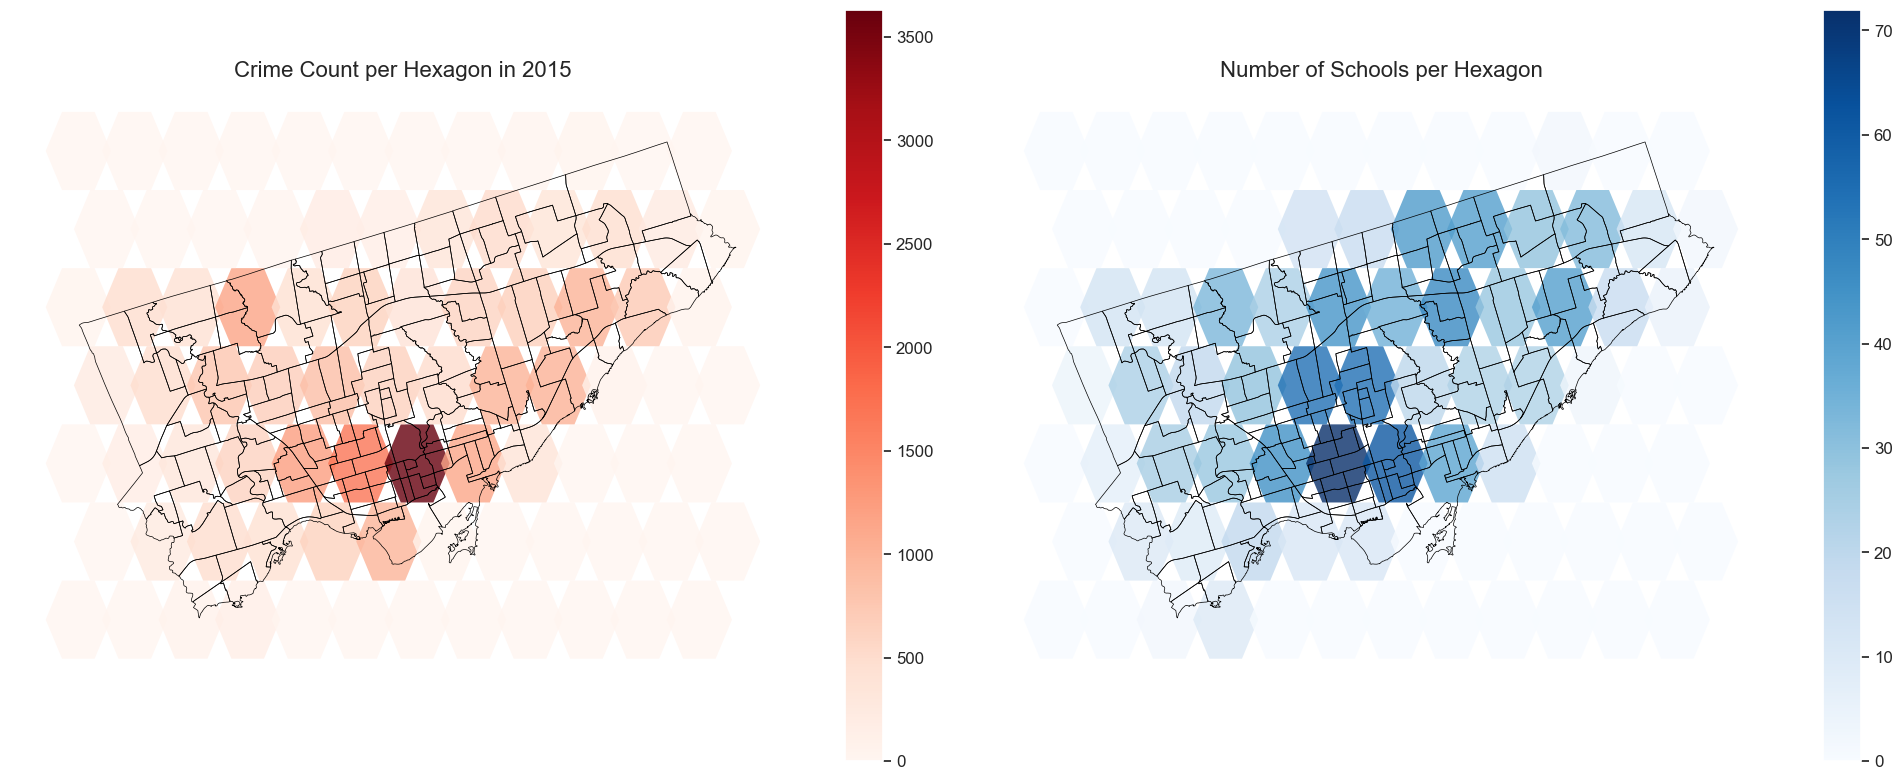

In [13]:

import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Point

YEAR = 2015

# Load hex grid
ddf_hex = dd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = gpd.GeoDataFrame(pdf_hex, geometry="geometry", crs="EPSG:4326")

# Filter crime to that year, then sum per hex
ddf_crime = dd.read_parquet(
    "s3://paul-project-bucket/features/crime_daily",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_crime = (
    ddf_crime
      .reset_index()                          
      .assign(year=lambda df: df.day.dt.year) 
      # boolean mask using .loc so YEAR is in scope
      .loc[lambda df: df.year == YEAR]
      .groupby("hex_id")
      .crime_n
      .sum()
      .rename("crime_count")
      .reset_index()
      .compute()
)

# Load & count schools (static)
df_sch = pd.read_csv(
    "s3://paul-project-bucket/features/schools.csv",
    storage_options={"anon": False},
    dtype={"LONGITUDE": float, "LATITUDE": float}
)
gdf_sch = gpd.GeoDataFrame(
    df_sch,
    geometry=gpd.points_from_xy(df_sch.LONGITUDE, df_sch.LATITUDE),
    crs="EPSG:4326"
)
pdf_sch = (
    gpd.sjoin(
        gdf_sch,
        gdf_hex[["hex_id", "geometry"]],
        how="left",
        predicate="within"
    )
    .groupby("hex_id")
    .size()
    .reset_index(name="school_count")
)

# Merge metrics back into hex grid
gdf = (
    gdf_hex
      .merge(pdf_crime, on="hex_id", how="left")
      .merge(pdf_sch,   on="hex_id", how="left")
)
gdf["crime_count"]  = gdf["crime_count"].fillna(0)
gdf["school_count"] = gdf["school_count"].fillna(0)

# Fetch neighbourhood boundaries
arcgis_url = (
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson"
)
nbhd = gpd.read_file(arcgis_url).to_crs(epsg=4326)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Crime in YEAR
gdf.plot(
    column="crime_count",
    cmap="Reds",
    legend=True,
    ax=axes[0],
    edgecolor="none",
    alpha=0.8
)
nbhd.boundary.plot(ax=axes[0], color="black", linewidth=0.5)
axes[0].set_title(f"Crime Count per Hexagon in {YEAR}", fontsize=16)
axes[0].axis("off")

# Schools
gdf.plot(
    column="school_count",
    cmap="Blues",
    legend=True,
    ax=axes[1],
    edgecolor="none",
    alpha=0.8
)
nbhd.boundary.plot(ax=axes[1], color="black", linewidth=0.5)
axes[1].set_title("Number of Schools per Hexagon", fontsize=16)
axes[1].axis("off")

plt.tight_layout()
plt.show()

### 3. Association Between School Density and Cumulative Crime per Hexagon (2014–2024)
The figure titled “School Density vs. Total Crime” brings together three complementary views—marginal densities for school counts and crime totals, plus a scatter with a fitted trend line—to assess the degree to which the concentration of educational institutions within a hexagon corresponds to its overall crime burden.

The top and right margins display kernel‐density estimates of the two variables. The density of schools per hexagon is right‐skewed, peaking around 15–30 institutions but extending up above 60 in a few downtown cells. Likewise, the total crime‐count distribution centers below 15 000 incidents yet has a long tail reaching to 50 000 or more, reflecting our previously identified hotspot hexagons.

At the core of the plot, each point represents one hexagon’s cumulative crime count plotted against its number of schools. The crimson fit line, together with the annotated Pearson correlation (r = 0.65, p = 1.15 × 10⁻⁶), reveals a moderately strong, highly significant positive association: hexagons hosting more schools tend also to register more crime over the study period. This pattern likely reflects the confluence of daytime population flows, youth activity, and the urban amenities surrounding campuses—which increase both opportunity and guardianship dynamics—as well as the fact that schools are often sited in denser urban cores where crime is higher for multiple reasons.

While causality cannot be asserted from this descriptive analysis alone, the strength and clarity of the relationship justify retaining school density as a key covariate in our ongoing spatiotemporal crime model. By doing so, we can more precisely disentangle the specific mechanisms—be they population exposure, land‐use interactions, or social‐environmental factors—through which educational infrastructure influences local crime patterns.

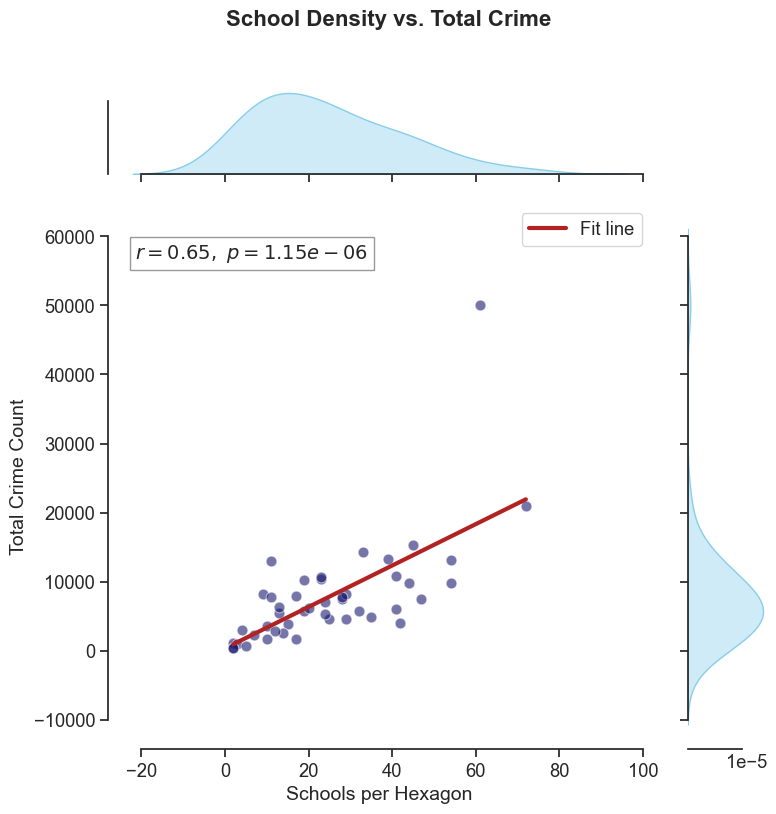

In [18]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, linregress

# Load only the needed cols
ddf_schools = dd.read_parquet(
    "s3://paul-project-bucket/features/school_counts_by_hex.parquet",
    storage_options={'anon': False},
    usecols=["hex_id", "school_count"]
)
pdf_schools = ddf_schools.compute()

# Aggregate total crime per hex
ddf_crime = dd.read_parquet(
    "s3://paul-project-bucket/features/crime_monthly_totals",
    storage_options={'anon': False},
    engine="pyarrow"
)
pdf_crime = (
    ddf_crime
      .groupby("hex_id")["total_crime"]
      .sum()
      .rename("crime_count")
      .reset_index()
      .compute()
)

# Merge
df = pd.merge(pdf_schools, pdf_crime, on="hex_id", how="inner")

# Corr & regression
x = df["school_count"].values
y = df["crime_count"].values
r, p = pearsonr(x, y)
slope, intercept, *_ = linregress(x, y)

# Fancy Joint‐Plot
sns.set_theme(style="ticks", font_scale=1.2)
g = sns.JointGrid(data=df, x="school_count", y="crime_count", height=8, ratio=5)

# scatter
g.plot_joint(
    sns.scatterplot,
    s=60, alpha=0.6, edgecolor="white", linewidth=0.7, color="midnightblue"
)

# regression line drawn directly
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = intercept + slope * x_vals
g.ax_joint.plot(x_vals, y_vals, color="firebrick", linewidth=3, label="Fit line")

# marginals
g.plot_marginals(sns.kdeplot, fill=True, alpha=0.4, color="skyblue")

# annotate r & p
g.ax_joint.text(
    0.05, 0.90,
    f"$r={r:.2f},\\ p={p:.2e}$",
    transform=g.ax_joint.transAxes,
    fontsize=14,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8)
)

# labels & title
g.ax_joint.set_xlabel("Schools per Hexagon", fontsize=14)
g.ax_joint.set_ylabel("Total Crime Count", fontsize=14)
g.fig.suptitle("School Density vs. Total Crime", fontsize=16, fontweight="bold", y=1.02)

# add legend for the fit line
g.ax_joint.legend(frameon=True)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

## Pedestrain

### 1. Distribution of Raw Monthly Pedestrian Counts (≤ 99th Percentile)
In the first pair of panels, I seek to understand the underlying distribution of our pedestrian‐count variable and justify the use of a log‐transform. The left histogram shows raw monthly pedestrian counts up to the 99th percentile, with a red dashed line marking that cutoff; the extreme right‐hand tail—reaching well over 100 000 counts—would otherwise dominate any untransformed analysis. By truncating at the 99th percentile, one can see that most hex–month observations lie below roughly 20 000 pedestrians, but a non-negligible fraction still extends into the tens of thousands. The right panel then displays the density of log​₁₊​(monthly_ped_count), complete with an overlaid KDE and a vertical line at its median value. This transformation compresses the heavy right tail and yields an approximately symmetric, unimodal distribution centered around log​₁₊​(≈6.8), providing a more tractable scale for both visualization and regression modeling.


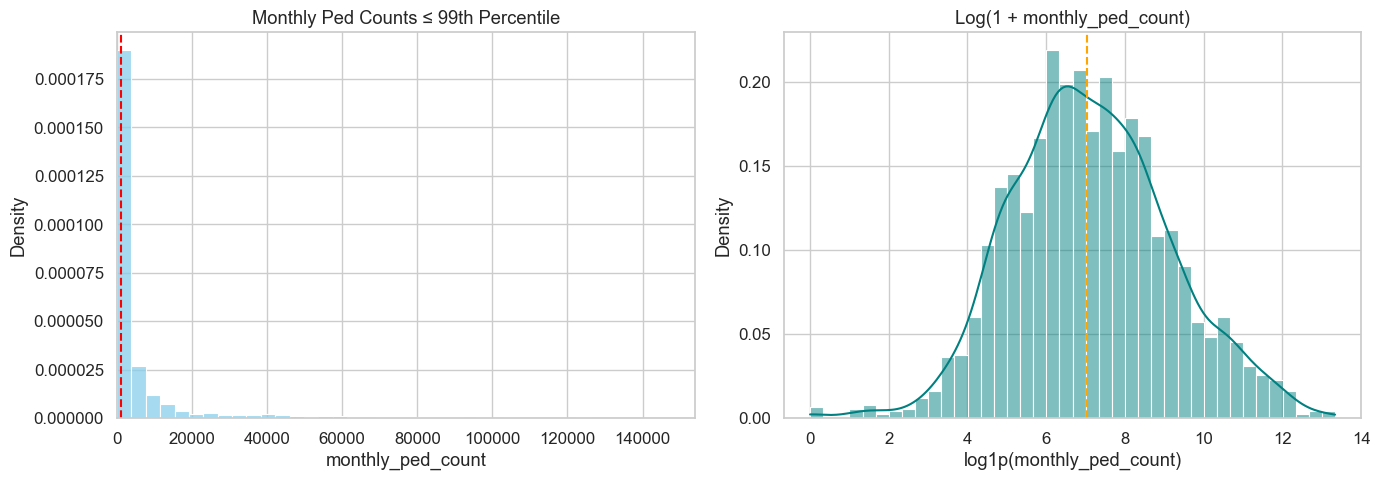

In [5]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load & compute
ddf_ped = dd.read_parquet(
    "s3://paul-project-bucket/features/monthly_hex_all",
    storage_options={"anon": False},
    engine="pyarrow"
).assign(
    month=lambda df: dd.to_datetime(df.month).dt.month
)
pdf = ddf_ped.compute()

# Prepare trimming & log‐transform
pct99 = pdf["monthly_ped_count"].quantile(0.99)
pdf["log_ped"] = np.log1p(pdf["monthly_ped_count"])

# Plot
sns.set_theme(style="whitegrid", font_scale=1.1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# Bulk distribution (<= 99th percentile)
sns.histplot(
    pdf.loc[pdf.monthly_ped_count <= pct99, "monthly_ped_count"],
    bins=40, stat="density",
    color="skyblue", edgecolor="white",
    ax=ax1
)
ax1.set_xlim(0, pct99)
ax1.axvline(pdf["monthly_ped_count"].median(), color="red", linestyle="--", lw=1.5)
ax1.set_title("Monthly Ped Counts ≤ 99th Percentile")
ax1.set_xlabel("monthly_ped_count")
ax1.set_ylabel("Density")

# Log1p-transformed distribution
sns.histplot(
    pdf["log_ped"],
    bins=40, stat="density",
    kde=True, color="teal",
    edgecolor="white", ax=ax2
)
med_log = pdf["log_ped"].median()
ax2.axvline(med_log, color="orange", linestyle="--", lw=1.5)
ax2.set_title("Log(1 + monthly_ped_count)")
ax2.set_xlabel("log1p(monthly_ped_count)")
ax2.set_ylabel("Density")

plt.tight_layout()
plt.show()

### 2. Average Monthly Pedestrian Footfall per Hexagon vs. Average Monthly Crime Incidents per Hexagon

The middle maps translate these pedestrian metrics into space and compare them directly with crime incidence. On the left, the average monthly pedestrian count per hexagon is rendered in shades of blue: the darkest cells, concentrated in the downtown core and along major transit corridors, register upwards of 70 000 pedestrians per month, while outlying suburbs remain below 10 000. On the right, the corresponding map of average monthly crime count per hexagon (in red) reveals a broadly similar—but not identical—pattern: the central business district again stands out with over 350 incidents per month on average, yet certain adjacent corridors exhibit elevated pedestrian footfall without a proportionate crime increase. These side-by-side spatial portraits underscore that while high foot‐traffic areas tend to coincide with high‐crime zones, local land‐use and environmental factors modulate the precise overlap.

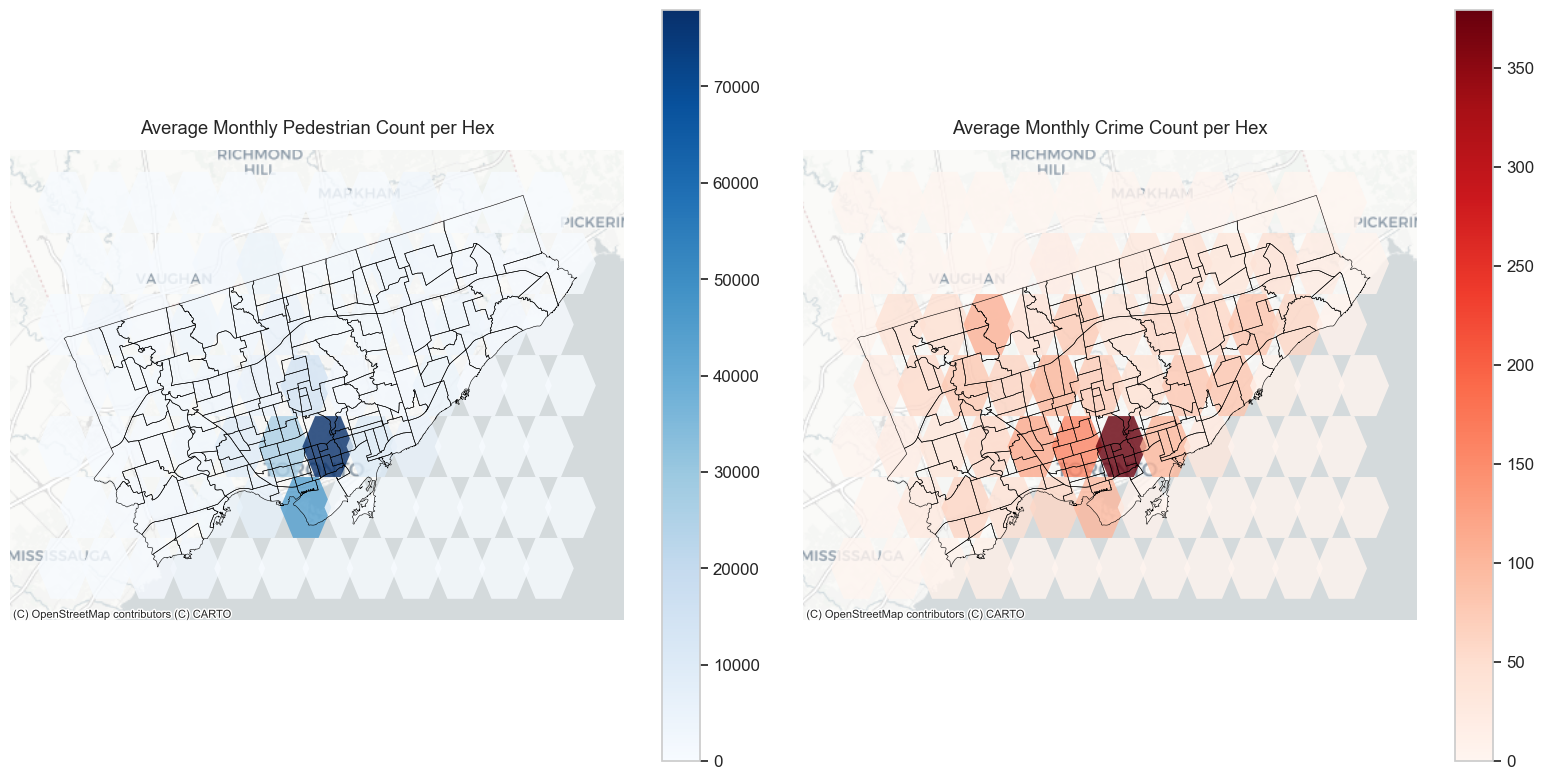

In [6]:
import dask.dataframe as dd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt

# Load hex grid & neighbourhoods (once)
ddf_hex = dd.read_parquet("s3://paul-project-bucket/grid/hex5000.parquet",
                          storage_options={"anon":False}, engine="pyarrow")
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = gpd.GeoDataFrame(pdf_hex[["hex_id","geometry"]],
                           geometry="geometry", crs="EPSG:4326").to_crs(epsg=3857)

nbhd = (gpd.read_file(
    "https://gis.toronto.ca/arcgis/rest/services/"
    "cot_geospatial26/MapServer/9/query?"
    "where=1%3D1&outFields=*&outSR=4326&f=geojson")
    .to_crs(epsg=3857)
)

# Load & merge annual averages
# (a) Pedestrian annual average
ddf_ped = dd.read_parquet("s3://paul-project-bucket/features/monthly_hex_all",
                          storage_options={"anon":False}, engine="pyarrow") \
           .assign(month=lambda df: dd.to_datetime(df.month).dt.month)
pdf_ped = ddf_ped.compute()
pdf_avg_ped = pdf_ped.groupby("hex_id")["monthly_ped_count"] \
                     .mean().reset_index().rename(columns={"monthly_ped_count":"avg_ped"})

# (b) Crime annual average
ddf_crime = dd.read_parquet("s3://paul-project-bucket/features/crime_monthly_totals",
                            storage_options={"anon":False}, engine="pyarrow")
pdf_crime = ddf_crime.compute()
pdf_avg_crime = pdf_crime.groupby("hex_id")["total_crime"] \
                         .mean().reset_index().rename(columns={"total_crime":"avg_crime"})

# Merge into grid
gdf_avg = gdf_hex.merge(pdf_avg_ped,  on="hex_id", how="left") \
                 .merge(pdf_avg_crime, on="hex_id", how="left") \
                 .fillna(0)

# ── Plot side-by-side ──
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

# Avg Ped Map
gdf_avg.plot(column="avg_ped", cmap="Blues", legend=True,
             ax=ax1, edgecolor="none", alpha=0.8)
nbhd.boundary.plot(ax=ax1, color="black", linewidth=0.4)
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, zoom=10)
ax1.set_title("Average Monthly Pedestrian Count per Hex", pad=12)
ax1.axis("off")

# Avg Crime Map
gdf_avg.plot(column="avg_crime", cmap="Reds", legend=True,
             ax=ax2, edgecolor="none", alpha=0.8)
nbhd.boundary.plot(ax=ax2, color="black", linewidth=0.4)
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, zoom=10)
ax2.set_title("Average Monthly Crime Count per Hex", pad=12)
ax2.axis("off")

plt.tight_layout()
plt.show()

### 3. Hex-Month Correlation: Pedestrian Volume vs. Crime Count
Finally, the correlation plot quantifies the hex–month relationship between pedestrian volume and crime. Each point represents one hexagon in a given month, plotted by its raw pedestrian count against its crime count, with kernel‐density marginals showing the skewed nature of both variables. The fitted red regression line and the annotated Pearson’s r = 0.46 (p ≈ 0) confirm a moderate, highly significant positive association: months and places with more pedestrian activity also report more crime. While this does not establish causality—pedestrian density may proxy for commercial activity, transit hubs, or other features—it provides strong empirical justification for including pedestrian footfall as a key covariate in our spatiotemporal crime model.

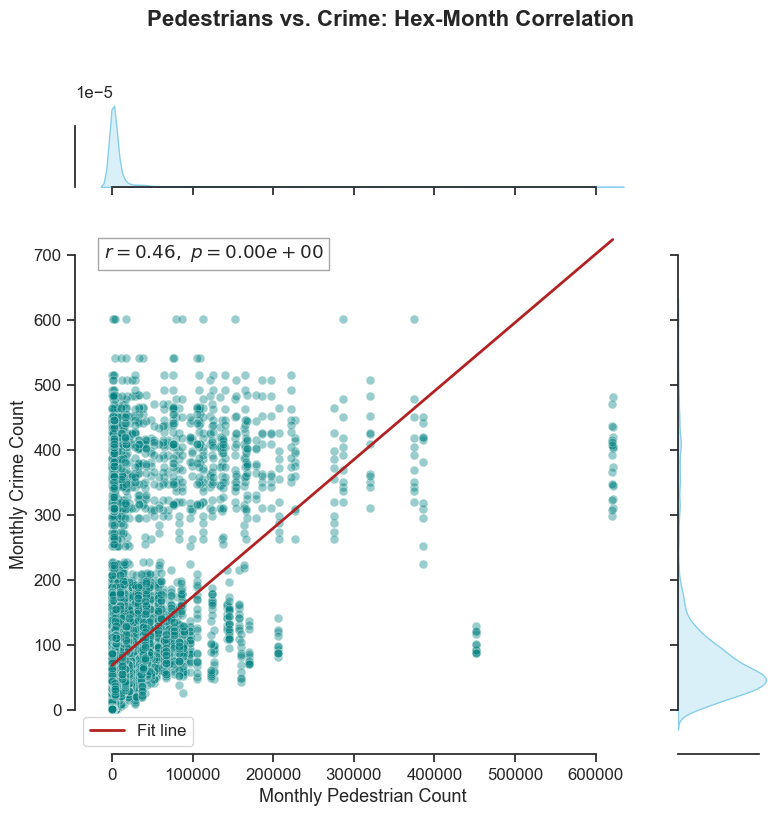

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

pdf_crime["month"] = pd.to_datetime(pdf_crime["month"]).dt.month

# Ensure pdf_ped.month is integer
pdf_ped["month"] = pdf_ped["month"].astype(int)

# Merge on now-matching dtypes
df_monthly = pd.merge(
    pdf_ped[["hex_id","month","monthly_ped_count"]],
    pdf_crime[["hex_id","month","total_crime"]],
    on=["hex_id","month"],
    how="inner"
).rename(columns={"total_crime":"monthly_crime_count"})

# 3) Compute stats
x = df_monthly["monthly_ped_count"].values
y = df_monthly["monthly_crime_count"].values
r, p = pearsonr(x, y)
slope, intercept, *_ = linregress(x, y)

# 4) Fancy JointGrid plot
sns.set_theme(style="ticks", font_scale=1.1)
g = sns.JointGrid(data=df_monthly,
                  x="monthly_ped_count",
                  y="monthly_crime_count",
                  height=8, ratio=5)

# scatter
g.plot_joint(
    sns.scatterplot,
    s=40, alpha=0.4,
    edgecolor="white", linewidth=0.5,
    color="teal"
)

# regression line
x_vals = np.linspace(x.min(), x.max(), 100)
g.ax_joint.plot(
    x_vals,
    intercept + slope*x_vals,
    color="firebrick",
    linewidth=2,
    label="Fit line"
)
g.ax_joint.legend(frameon=True)

# marginal KDEs
g.plot_marginals(
    sns.kdeplot,
    fill=True, alpha=0.3,
    color="skyblue"
)

# annotate Pearson r & p
g.ax_joint.text(
    0.05, 0.92,
    f"$r={r:.2f},\\ p={p:.2e}$",
    transform=g.ax_joint.transAxes,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7)
)

# labels & title
g.ax_joint.set_xlabel("Monthly Pedestrian Count", fontsize=13)
g.ax_joint.set_ylabel("Monthly Crime Count", fontsize=13)
g.fig.suptitle(
    "Pedestrians vs. Crime: Hex-Month Correlation",
    fontsize=16, fontweight="bold", y=1.02
)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

## Dataframe Merge

In [ ]:
import dask.dataframe as dd

# Read data
df_crime  = dd.read_parquet("s3://paul-project-bucket/features/crime_monthly_totals",
                            storage_options={"anon": False})
df_ndvi   = dd.read_parquet("s3://paul-project-bucket/features/ndvi_monthly_filled",
                            storage_options={"anon": False})
df_lst    = dd.read_parquet("s3://paul-project-bucket/features/lst_monthly_filled",
                            storage_options={"anon": False})
df_school = dd.read_parquet("s3://paul-project-bucket/features/school_counts_by_hex.parquet",
                            storage_options={"anon": False})
df_ped    = dd.read_parquet("s3://paul-project-bucket/features/daily_hex_all",
                            storage_options={"anon": False})\
               .rename(columns={"monthly_ped_count": "ped_count"})

for ddf in (df_crime, df_ndvi, df_lst, df_ped):
    ddf["month"] = dd.to_datetime(ddf["month"])

# Merge time-dependent datasets first (outer join to capture all hex/month combinations)
df = df_crime.merge(df_ndvi, on=["hex_id", "month"], how="outer")
df = df.merge(df_lst, on=["hex_id", "month"], how="outer")
df = df.merge(df_ped, on=["hex_id", "month"], how="outer")

# Merge school data (static dataset: left join to avoid NaN explosion)
df = df.merge(df_school, on=["hex_id"], how="left")  # No month in df_school!

# Fill school_count (static) and ped_count (time-dependent)
df["school_count"] = df["school_count"].fillna(0)
df["ped_count"] = df["ped_count"].fillna(0)

df.to_parquet(
    "s3://paul-project-bucket/features/monthly_features_v2_cleaned/",
    storage_options={"anon": False},
    engine="pyarrow",
    write_index=False,
    compression="snappy",
    partition_on=["month"]
)

In [33]:
client.close()
cluster.close()